In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import gseapy as gp
import scvelo as scv
from tqdm.auto import tqdm
from pathlib import Path

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
signatures_path = root / 'resources/'
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_path = config['data_path']
# local utils
sys.path.insert(1, '../utils/')
from utils import score_hallmarks, specify_genes, rsum, cluster_matrix
from utils import score_genes, get_ribo_percentage, plot_differential_test
from utils import run_progeny, obs_obs_aggregate_heatmap

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

# Loading

In [2]:
# Cached loading of macro data
cached = data_path / "Pancov19_prepd_neutros.h5"
if cached.is_file():
    mdata = sc.read(cached)
else:
    # Load data
    mdata = sc.read(data_path / "Cov19Hamster_timecourse_integrated_neutrophils.h5")
    mdata.obs['SCoV2_detected'] = mdata.obs['SCoV2_sum'] > 0
    # combined annotations for convenience
    mdata.obs['organism_time'] = [o+'_'+t for o, t in zip(mdata.obs['organism'], mdata.obs['time'])]
    mdata.obs['organism_dosage'] = [o+'_'+d for o, d in zip(mdata.obs['organism'], mdata.obs['dosage'])]
    mdata.obs['organism_dosage_time'] = [o+'_'+d+'_'+t for o, d, t in zip(mdata.obs['organism'], mdata.obs['dosage'], mdata.obs['time'])]
    
    # set pretty colors
    mdata.obs['time_num'] = [int(x[1:]) for x in mdata.obs.time]
    times = pd.unique(mdata.obs['time_num'])
    time_dict = dict(zip(times, np.arange(len(times))))
    mdata.obs['time_order'] = [time_dict[x] for x in mdata.obs.time_num]

    # filter genes to be expressed in at least a few cells and have at least a few counts in total
    limit_cells = (rsum(mdata.layers['counts']>0, axis=0) > 100)
    limit_counts = rsum(mdata.layers['counts'], axis=0) > 200
    mdata = mdata[:, limit_cells & limit_counts].copy()
    mdata.shape

    # remove outlier /low QC / doublet clusters, they will make diffusion and velocity analysis difficult
    mdata = mdata[~np.isin(mdata.obs.louvain_scVI, ['10', '12'])].copy()
    sc.tl.umap(mdata, min_dist=0.3, neighbors_key='neighbors_scVI')
    mdata.obsm['X_umap_scVI'] = mdata.obsm['X_umap']
    sc.tl.diffmap(mdata, neighbors_key='neighbors_scVI')
    
    # rig-I
    kegg_rigI='TANK,CHUK,MAPK14,CYLD,DDX3X,DDX58,TKFC,TBK1,IFNE,STING1,IFNA1,IFNA2,IFNA4,IFNA5,IFNA6,IFNA7,IFNA8,IFNA10,IFNA13,IFNA14,IFNA16,IFNA17,IFNA21,IFNB1,IFNW1,IKBKB,CXCL8,IL12A,IL12B,CXCL10,IRF3,IRF7,MAP3K1,NFKB1,NFKBIA,NFKBIB,PIN1,RNF125,OTUD5,MAPK8,MAPK11,MAPK9,MAPK10,MAPK13,IFNK,MAVS,RELA,MAPK12,IFIH1,AZI2,MAP3K7,TNF,TRAF2,TRAF3,TRAF6,TRIM25,DHX58,NLRX1,SIKE1,CASP8,CASP10,IKBKG,DDX3Y,TRADD,RIPK1,FADD,ATG12,ATG5,ISG15,IKBKE,TBKBP1'.split(',')
    genes = pd.unique(list(specify_genes(kegg_rigI, 'human', 'mouse')))
    sc.tl.score_genes(mdata, genes, score_name='kegg_rigI_score')

    # score progeny
    import decoupler as dc
    model = dc.get_progeny(organism='mouse', top=100)
    dc.run_mlm(mat=mdata, net=model, source='source', target='target', weight='weight', verbose=True, use_raw=False)
    for key in mdata.obsm['mlm_estimate'].columns: mdata.obs[f'{key}_progeny'] = mdata.obsm['mlm_estimate'][key]
    prokeys = [x for x in mdata.obs.keys() if 'progeny' in x]
    
    # hallmarks
    score_hallmarks(mdata, subset='all', species='mouse', signatures_path=signatures_path)
    
    # Zheng
    tab = pd.read_excel('../resources/Zheng_et_al_Table2.xlsx', sheet_name=0, skiprows=1)
    up = tab[(tab.log2FoldChange_batch1>0.5) & (tab.log2FoldChange_batch2>0.5)].gene_name  # Table S2.DEG for twice Bulk RNA-Seq (cov vs non-cov?)
    score_genes(mdata, up.values, 'Covid Signature (Zheng et al. Table2)', species='mouse')

    # Schulte-Schrepping
    tab = pd.read_excel('../resources/SchulteSchrepping_et_al_degs.xlsx', sheet_name=7, skiprows=[0,1,3], index_col=0)  # Marker genes for Cohort 2 neutrophil clusters
    tab.index=tab.index.astype(str)
    cluster_ids=['mature (control)',
                 'mature (severe)',
                 'mature (covid specific)',
                 'mature (control)',
                 'mature (control)',
                 'mature',
                 'pre-Neutros',
                 'mature',
                 'pro-Neutros']
    sig = {cluster_ids[x]+' (Schulte et al.)': tab.index[tab.cluster==x] for x in pd.unique(tab.cluster)}
    for k in sig.keys():
        score_genes(mdata, sig[k], score_name=k, species='mouse')
    
    # Antiviral genes for macrophages (I checked these genes, these are confirmed antiviral)
    antiviral_macro_genes = ['Mnda', 'Isg15', 'Mx1', 'Samhd1', 'Ifit3', 'Nmi', 'Apobec1', 'Samd9', 'Lgals9', 'Psme1', 'Herc6', 'Ifit2', 'Irf7', 'Lgals3bp', 'Parp9', 'Ly6e']
    score_genes(mdata, antiviral_macro_genes, 'antiviral_macro_score', 'mouse')

    # other
    get_ribo_percentage(mdata, species='mouse')
    mdata.write(cached)

In [3]:
# Import color options
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']

# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'$1\times10^4$ pfu',
    'high dose': r'$1\times10^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
    return s.replace('_', ', ')

# Capitalized obs keys are "sanitized" ones (i.e. mapped to new names)
for key in ['dosage', 'time', 'organism', 'organism_dosage', 'organism_dosage_time', 'organism_time']:
    mdata.obs['_'.join([x.capitalize() for x in key.split('_')])] = [sanitize_name(s) for s in mdata.obs[key]]

from matplotlib.cm import get_cmap
# not super pretty, but ok for now
time_colors = {
    'D0': 'grey',
    'D2': get_cmap('viridis_r')(0),
    'D3': get_cmap('viridis_r')(1/3),
    'D5': get_cmap('viridis_r')(2/3),
    'E14': get_cmap('viridis_r')(1),
              }
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(mdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in mdata.obs.organism_dosage_time.unique() if 'D0' not in x}

# Special Genes and pathways

Gene sets that were checked:
- Good: Hallmarks
- Somewhat useful: progeny
- Interesting: SOCS
- Maybe good: SchulteSchrepping_et_al_degs
- Not so useful: Cong et al
- Degranulation
    - Bad: https://maayanlab.cloud/Harmonizome/gene_set/neutrophil+degranulation/GO+Biological+Process+Annotations
    - Bad: https://www.gsea-msigdb.org/gsea/msigdb/cards/REACTOME_NEUTROPHIL_DEGRANULATION
- Zheng et al (Bad): genes = ['Cd177', 'Ngp', 'Camp', 'Ltf']+['Il1b', 'Tnfaip3', 'Nfkbiz']+['Slc11a1', 'Serpina1', 'Ifngr1', 'Cyba']


## Cherry-picked genes

In [ ]:
special_genes = {
    'chemoattractant-receptors': ['Cxcr4'],
    'activating inflammation factors': ['Tnf', 'Il1b'],
    'PRRs': ['Tlr2', 'Tlr4', 'Ddx58', 'Ifih1'],  # Ddx58 is RIG-I, Ifih1 is MDA-5
    'NOD-like PRRs': ['Nlrc5'],
    'activation +': ['Cd63'], # Fcgr1 is Cd64, Itgam is Cd11b, Ceacam1 is Cd66
    'activation -': ['Sell'],  # Sell is Cd62l, Cxcr2 is Cd182
    'Oxidative stress': 'Jun, Fos, Ring1, Cdkn2d, Ubb, Ubc'.split(', '),
    'Zheng et al': 'Lrg1, Cxcl9, Serpine1, Aplnr, Apod, Acod1,Il1a, Sema6b, Hcar2, Angptl1'.split(', '),
    'SOCS': 'Stat1, Stat2, Soc1, Socs2, Socs3, Socs4, Il4r, Igf1r'.split(', '),
    'From DEtests': 'Calhm6, Ly6e, S1008a, Wars1, Ido1, Ucp2, Upp1, Xdh, Nupr1'.split(', '),
    'Core infection': 'Isg15 Isg20 Rsad2 Cxcl11 Usp18 Cxcl10 Irf7 Ifit2 Ifit3 Xdh Apol11a Upp1 Ucp2 Herc6 Mx2 Mx1 Nfkbia Birc3 Gbp2 Ifit1bl Shisa5'.split(' '),
    'Core anti-infection': 'Myct1 Gas6 Cyyr1 Emp2 Stmn1 Ltc4s Bmpr2 Cavin1 Cavin2 Vim Tspan7 Tspan13'.split(' '),
}

In [ ]:
neutrophil_selection = [
    'S100a9', 'S100a8', 'S100a6', #S100'
    'Hmgb2', 'Pglyrp1', 'Mmp8', 'Serpinb1',  # DC1 naive
    'Rsad2', 'Isg15', 'B2m', 'Xdh', 'Mx1', 'Mx2', 'Mnda', 'Samhd1', 'Ifit2', 'Ifit3', 'Irf7', 'Nmi', 'Apobec1', 'Samd9', 'Lgals9', 'Psme1', 'Herc6', 'Lgals3bp', 'Parp9', 'Ly6e', # Infection probably
    'Cd14', 'Fth1', 'Ccl3', 'Ccrl2', 'Cd274', 'Icam1', 'Rtp4', 'Slc15a3', 'Psmb8', 'Plac8', 'Cxcl10', 'Marcksl1', 'Ralgds', 'Ccl4', 'Ube2l6', 'Srgn', 'Cd74', 'Snx10', 'Plin3',   # DC1 active I
    'Sdc4', 'Csf1', 'Socs1', 'Usp18', 'Il1rn', 'Fas', 'Tap1', 'Isg20', 'Apol11a', 'Gpr84', 'Skil', 'Rhoh', # DC1 active II
    'Lst1', 'Marcks', 'Arg1', 'Ctsh', 'Fcgr1a',  # DC2 Naive (0)
    'Camp', 'Alox5ap', 'Ifitm6', 'Lcn2', 'Ifi27l2b', 'H3f3b', 'Rpsa', 'Tspo', 'Ldha', 'Oas1c', 'Pfn1', 'Lyz2',  # DC2 Active (1)
    'Bst2', 'Txnip', 'Oasl',  # DC4 AV (left)
    'Sod2', 'Junb', 'Il1b', 'Socs3', 'Oaz1', 'Prdx5', 'Ube2d3', 'Gmfg', 'Ctsh', 'Aprt',  # DC4 ROS/degranule (right)
]
best = '''Rsad2, Isg15, B2m, Mx1, Mx2, Mnda, Samhd1, Ifit2, Ifit3, Irf7, Nmi, Apobec1, Samd9, Lgals9, Herc6, Lgals3bp, Parp9, Ly6e, Cd14, Ccl3, Ccrl2, Rtp4, Slc15a3, Psmb8, Plac8, Cxcl10, Marcksl1, Ccl4, Ube2l6, Cd74, Snx10, Socs1, Usp18, Il1rn, Fas, Tap1, Isg20'''.split(', ')

In [ ]:
genes = ["B2m","Ifit3","Mnda", "Psmb9", "Psme1", "Psmb8", "Rsad2", "Rtp4", "Hp", "Nmi", "Upp1", "Fabp5", "Ube2l6","Parp14","Mx1", "Samhd1","Npl", "Trib1", "Fpr1", "Parp9","Atp6v1g1","Dtx3l","Tap1","Trem1","Apobec1","Isg15"]


In [7]:
r4='Csf1,Hp,Hmox1,Csrp1,Hcar2,Rpl32,Upp1,B2m,S100a11,Mnda,Nfkbia,Mx1,Rtp4,Stx11,Socs3,Plek,Eif1,Ccl3,Psme1'.split(',')  # run4
r3='Fgl2,Npl,Sod2,Cmpk2,Csrnp1,Slc16a3,Rnf149,Nmi,Samhd1,Resf1,Slfn5,Psmb8,Ifit3,Vdac2,Parp9,Rsad2,Ftl,Calm2,Mx2,Osm,Bri3,Aph1b,Ccl5,Serp1,Stx11,Ppp1r15a'.split(',')   # run3
r2='Calm1,Ube2d3,Hsbp1,Anxa2,Irf9,Vmp1,Hspa8,Bst2,Ctss,Gpx1,Glul,Sell,Adam8,Hopx,Fas,Itgam,Rpsa,Irf7,Emb,Cd24,Ifih1'.split(',')   # run2

r1_1='Ifi27,Ifit1bl,Usp18,Cxcl10,Isg15,Ddx58,Herc6,Ifit2,Isg20,Apobec1,Dhx58,SCoV2_UTR3,Socs1,Samd9,Nlrc5,Lgals9,Dynlt1,Shisa5,Ogfr,Sp110,Lgals3bp,Trafd1,Psmb9,Tmsb10,Ddx60,\
Tifab,Ccrl2,Uba7,Casp3,Eva1b,Atf3,Marcksl1,Helz2,Parp12,Parp14,Dtx3l,Eif2ak2,Lmo2,Fabp5,Mitd1,Tent5a,Shfl,Cd274,Snx10,Clec7a,Lgals8,Serping1,Cd14,Tap1,Parp10,Srgn,Lamp2,\
Il1r2,Psma5,Cst7,Slc15a3,Dnajc3,Epsti1,Il1rn,Stat1,Abcb10,Stat2,Clic4,Chpt1,Cxcl16,Ptpn6,Wars1,Psme2,Dapp1,Sec11c,Tmco6,P2ry2,Irf1,Hfe,Sod2,Psme1,Ccl4,Plin2,Mcemp1,Hcar2,Clec5a,Cxcl11,Stx11,\
Smchd1,Cebpb,Setx,Abcb1a,Plgrkt,Cxcl3,Icam1,Lat2,Cd80,Clec4e,Fth1,Mxd1,Cd300a,Slamf1,Csf2ra,Il15ra,Bak1,Csrp1,SCoV2_orf1ab_p2,Cd79a,Ccnd3,Tlr2,Nod2,C2,Tspo,Ccl3,Surf4,Bri3,Hilpda,Degs1,\
Dgcr2,Il4r,Dhx34,Tes,Fn1,Nlrc4,Ffar2,Scimp,Plin3,Lrg1,Plac8,Mknk1,Hcst,Nt5e,Socs3,Osm,Timp1,Nfkb2,'.split(',')   # run1 DwarfD2
r1_2='Trib3,Ccr9,Klf4,Fgl2,Fosb,Ctsd'.split(',')   # run1 DwarfD3
r1_3='Cfb,Psmb10,Scgb1a1,Ibsp,Ly6e,Trex1,Ccl8,Fpr2,Vat1'.split(',')   # run1 GoldD2
r1_4='Fcgr4,Serp1,Mcl1,Klf2,Srsf2,Jund,Cd38,Kras,Ebi3,Alas1,Nod1,Nqo2,Rassf4,Nme8,Calcoco2,Cd40,Gpx1,Cd74'.split(',')   # run1 GoldD5

In [9]:
r=list(pd.unique(r1_1+r1_2+r1_3+r1_3+r2+r3+r4))
len(r)

202

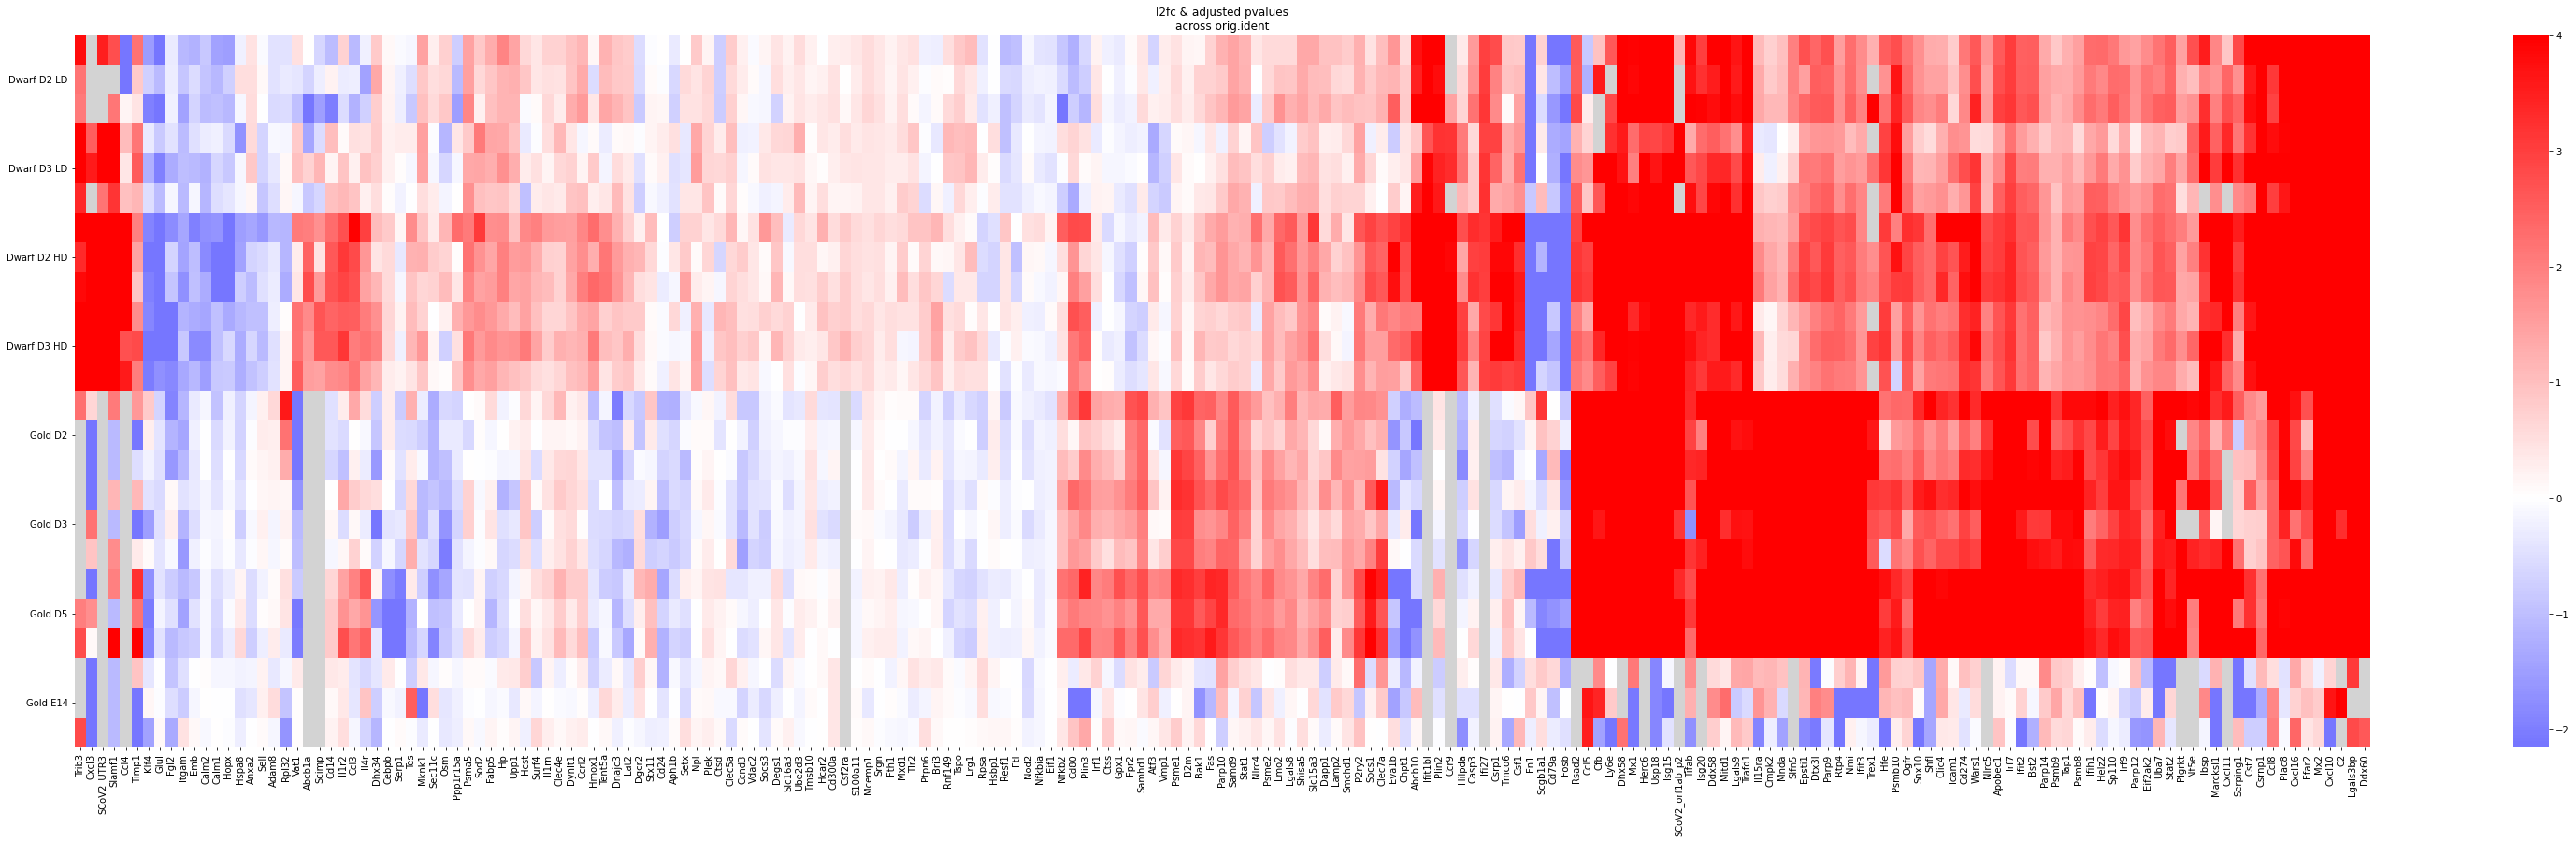

In [203]:
pl.figure(figsize=[55,14])
plot_differential_test(mdata, r, 'orig.ident', control=control_dict, sort_groups=False, cluster='col', show=False, annotate=False, vmax=4)
pl.yticks(np.arange(8)*3+1.5, ['Dwarf D2 LD', 'Dwarf D3 LD', 'Dwarf D2 HD', 'Dwarf D3 HD', 'Gold D2', 'Gold D3', 'Gold D5', 'Gold E14'])
pl.savefig(f'{figure_path}Neutro_DEGs.pdf', bbox_inches='tight', dpi=300)
pl.show()

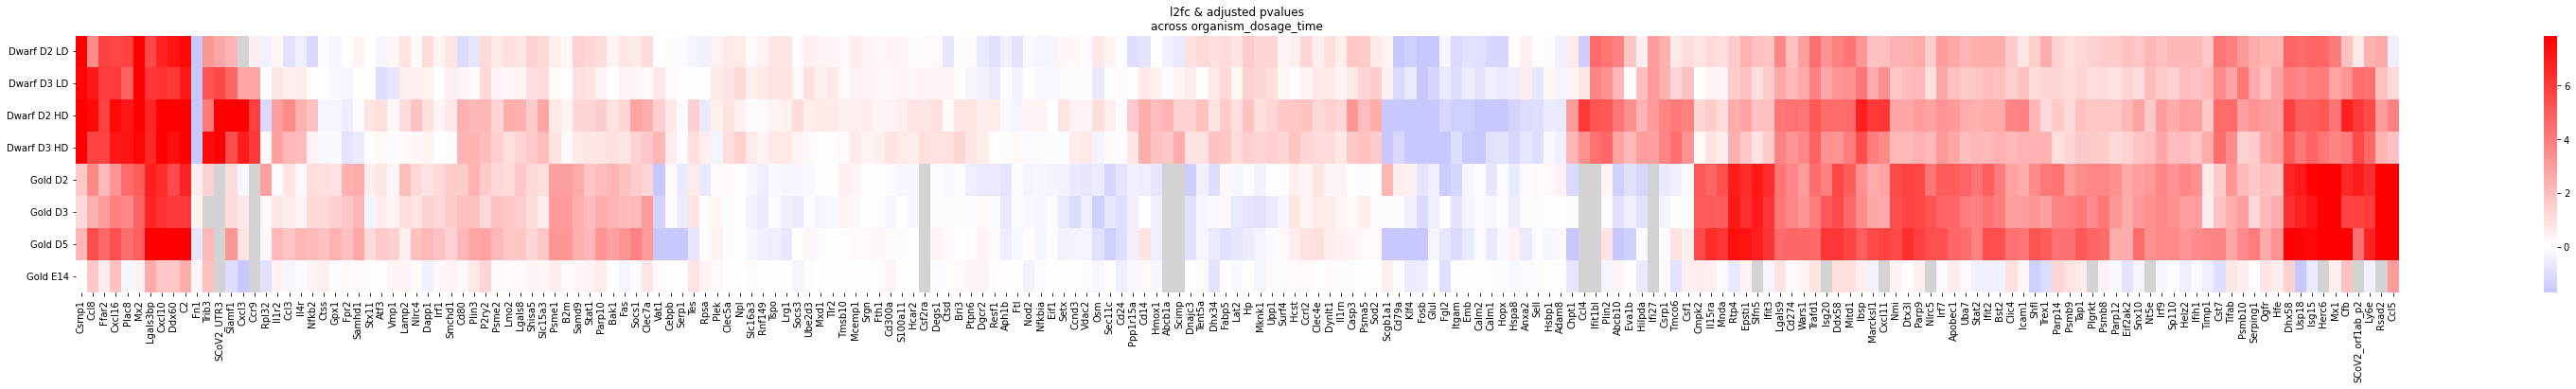

In [14]:
pl.figure(figsize=[55,5])
plot_differential_test(mdata, r, 'organism_dosage_time', control=control_dict_odt, sort_groups=False, cluster='col', show=False, annotate=False)
pl.yticks(np.arange(8)+0.5, ['Dwarf D2 LD', 'Dwarf D3 LD', 'Dwarf D2 HD', 'Dwarf D3 HD', 'Gold D2', 'Gold D3', 'Gold D5', 'Gold E14'])
pl.savefig(f'{figure_path}Neutro_DEGs_collapsed.pdf', bbox_inches='tight', dpi=300)
pl.show()

## hallmarks

In [50]:
hallmarks = list(mdata.obs.columns[mdata.obs.columns.str.contains('HALLMARK')])

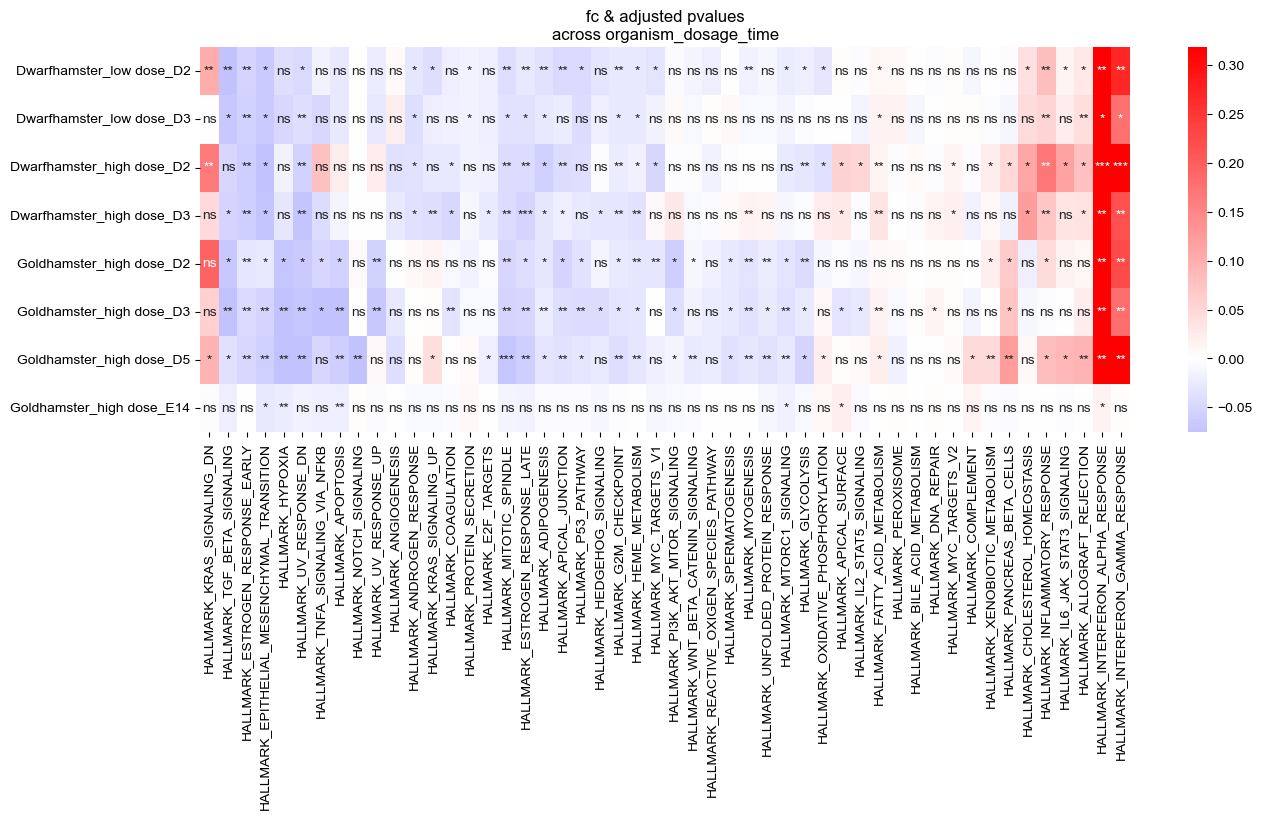

In [54]:
pl.subplots(figsize=[15,5])
ax = plot_differential_test(mdata, hallmarks, 'organism_dosage_time', cluster='col',
                       control=control_dict_odt, replicate_key='orig.ident', change='fc', show=False)

## progeny

In [34]:
run_progeny(mdata, species='mouse')
prokeys = [x for x in mdata.obs.keys() if 'progeny' in x]

Running mlm on mat with 10136 samples and 6567 targets for 14 sources.


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


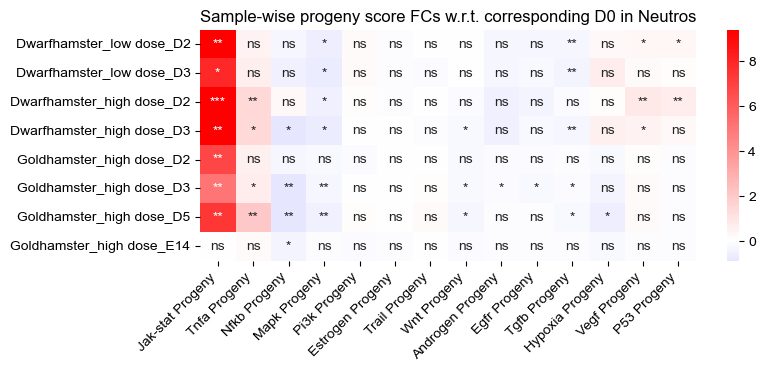

In [44]:
fig, ax = pl.subplots(figsize=[8,3], dpi=100)
ax = plot_differential_test(mdata, prokeys, 'organism_dosage_time', cluster='col',
                       control=control_dict_odt, replicate_key='orig.ident', change='fc',
                       show=False)
labels = [item.get_text() for item in ax.get_xticklabels()] 
pl.xticks(np.arange(len(labels))+0.5, 
          [' '.join([y.capitalize() for y in x.replace('HALLMARK_', '').split('_')]) for x in labels], 
          rotation=45, ha='right')
pl.title('Sample-wise progeny score FCs w.r.t. corresponding D0 in Neutros')
pl.savefig(figure_path / f'Progeny_fcs.pdf', bbox_inches='tight')
pl.show()

## Suppressor of cytokine signaling

"The suppressor of the cytokine signaling proteins (SOCS) family is one of the main regulators of the innate immune response induced by microbial pathogens. They mainly participate in the negative feedback regulation of cytokine signal transduction through Janus kinase signal transducer and transcriptional activator (JAK/STAT) and other signal pathways. Taken together, this paper reviews the SOCS proteins structures and the function of each domain, as well as the latest knowledge of the role of SOCS proteins in innate immune caused by viral infections and the mechanisms by which SOCS proteins assist viruses to escape host innate immunity. Finally, we discuss potential values of these proteins in future targeted therapies." - https://doi.org/10.3389/fimmu.2020.558341

CIS(H) is involved in the negative regulation of cytokines that signal through the JAK-STAT5 pathway such as erythropoietin, prolactin and interleukin 3 (IL3) receptor. Inhibits STAT5 trans-activation by suppressing its tyrosine phosphorylation.

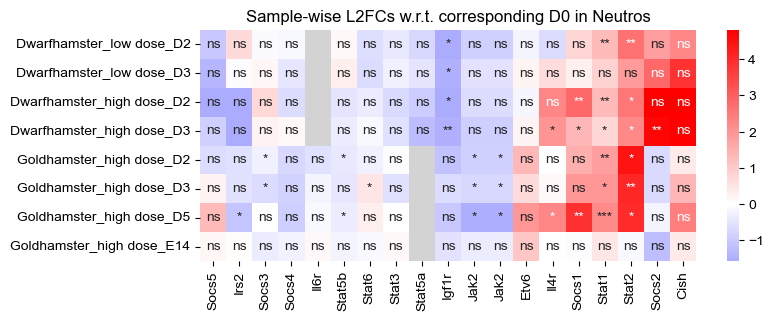

In [62]:
# Suppressor of cytokine signaling (SOCS) genes

genes = ['Socs1', 'Il6r', 'Irs2', 'Jak2', 'Etv6', 'Jak2', 'Socs2', 'Il4r', 'Igf1r', 'Socs3', 'Socs4', 'Socs5', 'Cish', # SOCS and targets (Cish is a SOCS)
         'Stat1', 'Stat2', 'Stat3', 'Stat5a', 'Stat5b', 'Stat6',  # SOCS is aka Stat-induced STAT inhibitor
        ]

fig, ax = pl.subplots(figsize=[8,3], dpi=100)
ax = plot_differential_test(mdata, genes, 'organism_dosage_time', cluster='col',
                       control=control_dict_odt, replicate_key='orig.ident', change='l2fc',
                       show=False)
pl.title('Sample-wise L2FCs w.r.t. corresponding D0 in Neutros')
pl.show()

## SchulteSchrepping_et_al sig (almost all signatures go down after infection)

In [28]:
tab = pd.read_excel('../resources/SchulteSchrepping_et_al_degs.xlsx', sheet_name=7, skiprows=[0,1,3], index_col=0)  # Marker genes for Cohort 2 neutrophil clusters
tab.index=tab.index.astype(str)
cluster_ids=['mature (control)',
             'mature (severe)',
             'mature (covid specific)',
             'mature (control)',
             'mature (control)',
             'mature',
             'pre-Neutros',
             'mature',
             'pro-Neutros']
sig = {cluster_ids[x]: specify_genes(tab.index[tab.cluster==x], 'human', 'mouse') for x in pd.unique(tab.cluster)}

for k in sig.keys():
    sc.tl.score_genes(mdata, sig[k], score_name=k)

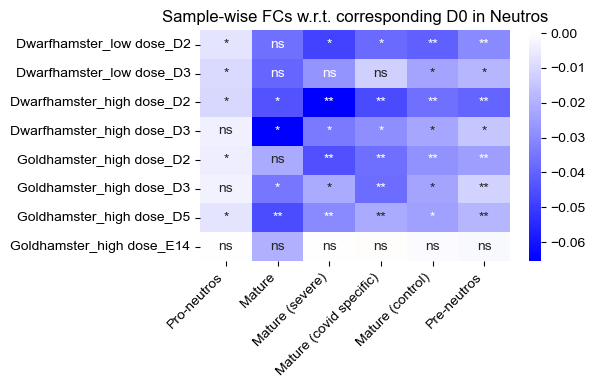

In [40]:
fig, ax = pl.subplots(figsize=[5,3], dpi=100)
ax = plot_differential_test(mdata, list(sig.keys()), 'organism_dosage_time', cluster='col',
                       control=control_dict_odt, replicate_key='orig.ident', change='fc',
                       show=False)
labels = [item.get_text() for item in ax.get_xticklabels()] 
pl.xticks(np.arange(len(labels))+0.5, 
          [' '.join([y.capitalize() for y in x.replace('HALLMARK_', '').split('_')]) for x in labels], 
          rotation=45, ha='right')
pl.title('Sample-wise FCs w.r.t. corresponding D0 in Neutros')
# pl.savefig(figure_path / f'Progeny_fcs.pdf', bbox_inches='tight')
pl.show()

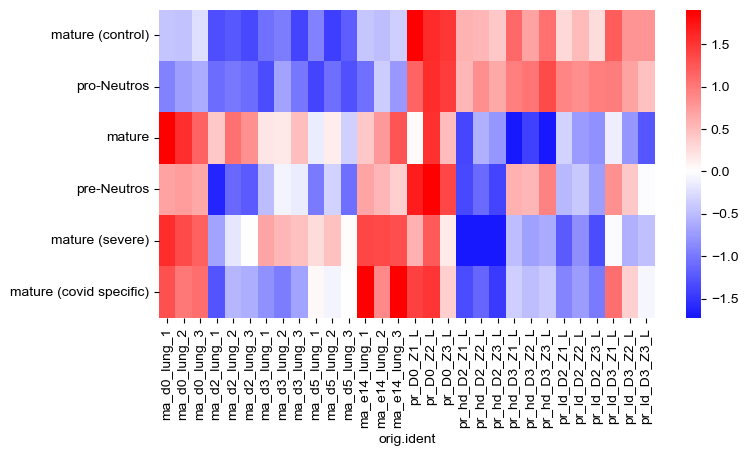

In [39]:
df = obs_obs_aggregate_heatmap(mdata, (sig.keys()), 'orig.ident', plot=False)
df = cluster_matrix(df, 'row')
pl.subplots(figsize=[8,4], dpi=100)
sns.heatmap(df, robust=True, cmap='bwr', center=0)
pl.show()

# Diffusion Analysis

Note: DC2 are doublets

In [4]:
# Flip diffmap DC1, DC3. Ordering was arbitrary (eigenvectors are unique up to flips).
mdata.obsm['X_diffmap'][:,1] = -mdata.obsm['X_diffmap'][:,1]
mdata.obsm['X_diffmap'][:,3] = -mdata.obsm['X_diffmap'][:,3]

## Embeddings (Fig 4A)

In [5]:
organism_dosage_time_colors = config['organism_dosage_time_colors']
Organism_Dosage_Time_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_time_colors'].items()}

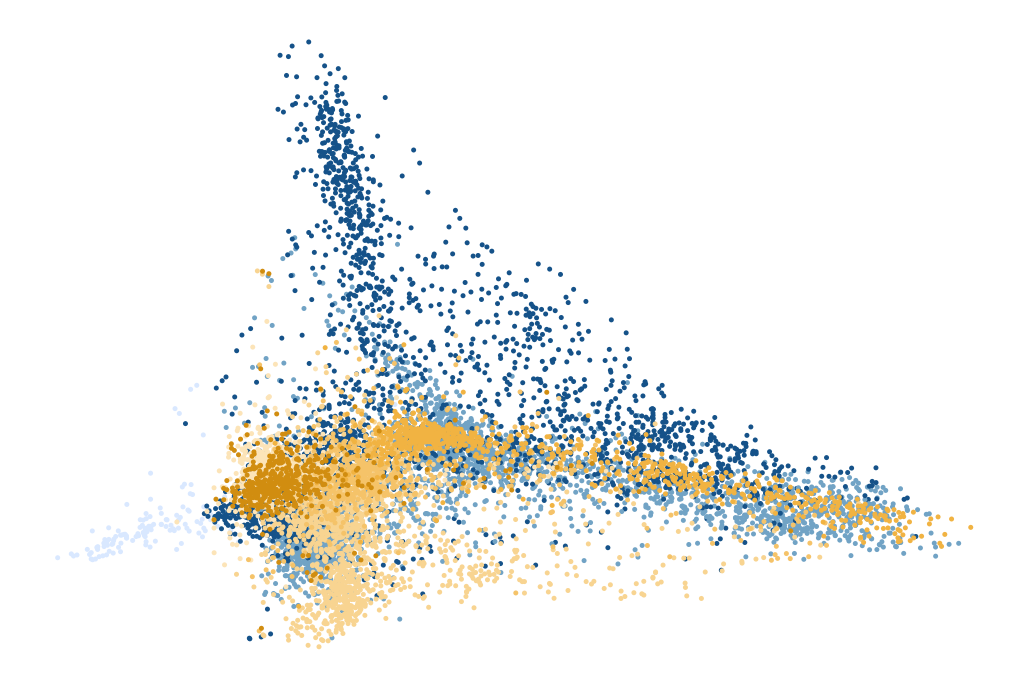

In [6]:
scale = 1.8
# fig, ax = pl.subplots(1,1, figsize=[6*scale,4*scale], dpi=120)
# idx=[mdata.obs.index[mdata.obs.Organism_Dosage_Time == odt][0] for odt in mdata.obs.Organism_Dosage_Time.unique()]
# ax = scv.pl.scatter(mdata[idx], basis='diffmap', color='Organism_Dosage_Time', 
#                     components='1,3', legend_loc='best', show=False, 
#                     title='Diffusionmap of Neutrophils (DC1,DC3)', ax=ax,
#                     palette=Organism_Dosage_Time_colors, s=20*scale, alpha=0
#                     )
# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)
# pl.savefig(figure_path / f'Fig4A_Neutro_diffmap_DC1DC3_ODT.pdf', bbox_inches='tight', dpi=300)
# pl.close()

fig, ax = pl.subplots(1,1, figsize=[6*scale,4*scale], dpi=120)
ax = scv.pl.scatter(mdata, basis='diffmap', color='Organism_Dosage_Time', 
                    components='1,3', legend_loc=False, show=False, 
                    title='', ax=ax,
                    palette=Organism_Dosage_Time_colors, s=20*scale,
                    )
pl.savefig(figure_path / f'Fig4A_Neutro_diffmap_DC1DC3_ODT.png', bbox_inches='tight', dpi=300)
pl.show()



In [7]:
# strict sort order for plotting
mdata.obs.Organism_Dosage_ = mdata.obs.Organism_Dosage.astype(str)
mdata.obs.Organism_Dosage_.replace({
'Roborovski hamster, 0 pfu': 2,
'Roborovski hamster, $1\\times10^4$ pfu': 3,
'Roborovski hamster, $1\\times10^5$ pfu': 4,
'Syrian hamster, 0 pfu': 0,
'Syrian hamster, $1\\times10^5$ pfu': 1
}, inplace=True)
index = mdata.obs.Organism_Dosage_.sort_values().index

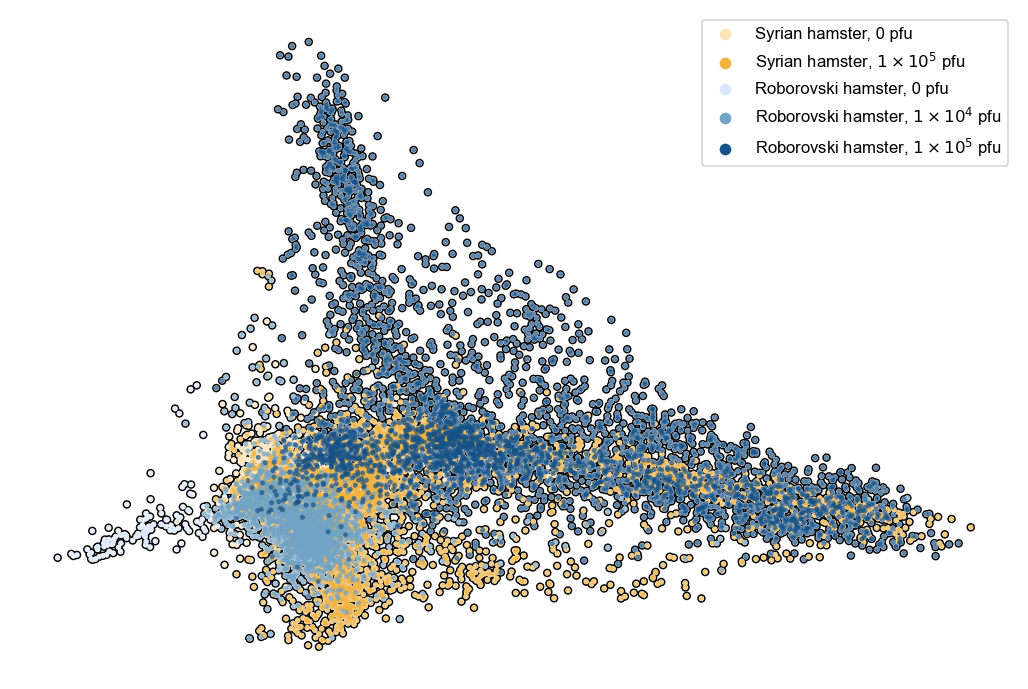

In [8]:
fig, ax = pl.subplots(1,1, figsize=[6*scale,4*scale], dpi=120)
ax = scv.pl.scatter(mdata[index], basis='diffmap', color='Organism_Dosage', 
                    components='1,3', legend_loc='best', show=False, 
                    title='', ax=ax, alpha=0.7, add_outline=True,
                    palette=Organism_Dosage_colors, s=20*scale,
                    )
ax.legend_.get_texts()
handles, labels = ax.get_legend_handles_labels()
order = [4, 3, 2, 0, 1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
pl.savefig(figure_path / f'Fig4A_Neutro_diffmap_DC1DC3_OD.png', bbox_inches='tight', dpi=300)
pl.show()


## Explanation / Latent ANOVA (Fig 4B)

In [15]:
# define features for ANOVA to test
columns = mdata.obs.columns
c_progeny = list(columns[columns.str.contains('progeny')])
# Exclude hallmarks that always pop up in any analysis and are not interesting
exclude_hallmarks = ['HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_ADIPOGENESIS',
                     'HALLMARK_KRAS_SIGNALING_DN', 'HALLMARK_KRAS_SIGNALING_UP',
                     'HALLMARK_UV_RESPONSE_DN', 'HALLMARK_UV_RESPONSE_UP'
                     ]
c_hallmark = [c for c in columns[columns.str.contains('HALLMARK')] if c not in exclude_hallmarks]
c_sample = ['time', 'organism', 'dosage']  # sample-wise keys
c_percell = ['SCoV2_detected', 'SCoV2_load', 'percent_ribo', 'kegg_rigI_score']  # other keys per cell

keys = c_progeny + c_hallmark + c_sample + c_percell

# display style
rename_dict={
            'kegg_rigI_score': 'RIG-I pathway (KEGG)',
            'SCoV2_detected': 'SARS-CoV-2 found in cell',
            'percent_ribo': 'Percent ribosomal counts',
            'SCoV2_load': 'SARS-CoV-2 quantity in cell',
            'time': 'Time after infection',
            'organism': 'Organism (Roborovski / Syrian)',
            'dosage': 'Viral dosage given',
            **{key: key.replace('_progeny', ' signaling (progeny)') for key in c_progeny},
            **{key: key.replace('HALLMARK_', '').capitalize().replace('_', ' ')+' (MSigDB)' for key in c_hallmark}
            }

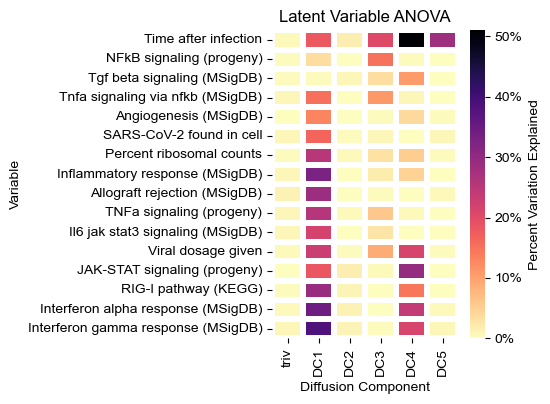

In [21]:
# ANOVA
mat = getExplanatoryPCs(mdata, keys, use_rep='X_diffmap')
mat = mat.rename(index=rename_dict)
mat = mat[mat.max(1) > 10]  # keep keys that explain at least 10% of the variance
mat = cluster_matrix(pd.DataFrame(mat.values.astype(float), index=mat.index, columns=mat.columns), how='row')
fig, ax = pl.subplots(figsize=[3,4], dpi=100)
plotExplanatoryPCs_heatmap(mat, N_components=6, show=False, ax=ax)
pl.savefig(figure_path / f'Fig4B_DiffusionANOVA.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [12]:
# Export for supplementary table
mat.to_csv(table_path / f'Fig4B_source.csv')

## Binarize DC1

In [5]:
i = 1
mdata.obs[f'DC{i}'] = mdata.obsm['X_diffmap'][:,i]
mdata.obs['replicate'] = [x[2] for x in mdata.obs.hamster]

# Binarize DC
p_off = 0
range_percs = [p_off, 100-p_off]
n_bins=50
X = mdata.obs[f'DC{i}']
xmin = np.percentile(X, range_percs[0])
xmax = np.percentile(X, range_percs[1])
numbers, bins = np.histogram(X, range=[xmin, xmax], bins=n_bins)

In [6]:
# Linearly correlate each gene with DC1
df_corr = lin_corr_adata(mdata, mdata.obsm['X_diffmap'][:,i], mdata.var_names, method='spearman')

100%|██████████| 6567/6567 [00:07<00:00, 856.40it/s]


## Densities

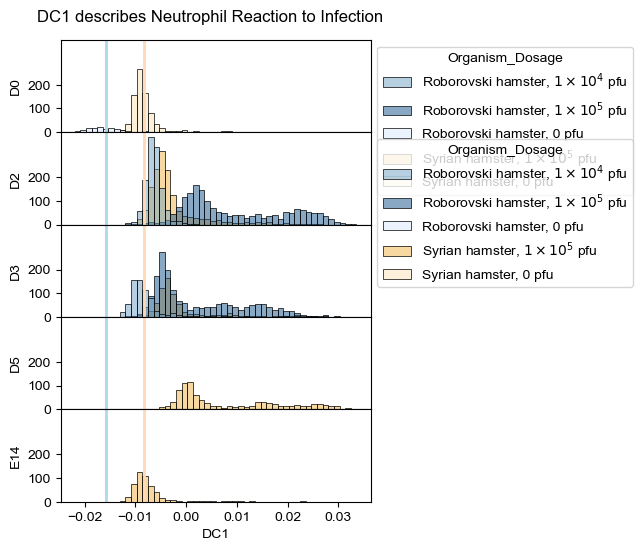

In [85]:
fig, axs = pl.subplots(5, 1, sharex=False, figsize=[4,6], dpi=100, sharey=True)
m_dwarf = np.mean(mdata.obs.DC1[(mdata.obs.time=='D0')&(mdata.obs.Organism=='Roborovski hamster')])
m_gold = np.mean(mdata.obs.DC1[(mdata.obs.time=='D0')&(mdata.obs.Organism=='Syrian hamster')])
for i, t in enumerate(pd.unique(mdata.obs.time)):
    ax = axs[i]
    add_legend = (i == 0) or (i == 1)
    sns.histplot(data=mdata.obs[mdata.obs.time==t], x='DC1', 
                 hue='Organism_Dosage', ax=ax, bins=bins, 
                 legend=add_legend, linewidth=0.5,
                 palette=Organism_Dosage_colors
                )
    #ax.set_xticks([])
    #ax.set_xticklabels([])
    ax.set_yticks([0, 100, 200])
    ax.set_ylabel(f'{t}')
    ax.axvline(m_gold, linewidth=2, color='peachpuff')
    ax.axvline(m_dwarf, linewidth=2, color='lightblue')
    if add_legend:
        sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
 
pl.subplots_adjust(hspace=0)
#axs[-1].set_xticks([(m_dwarf+m_gold)/2])
#axs[-1].set_xticklabels(['Ground States\n(Mean DC1 before infection)'])
pl.suptitle('DC1 describes Neutrophil Reaction to Infection', y=0.93)
pl.savefig(figure_path / f'Fig4C_Neutro_DC1_dynamics_histplot.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [57]:
# Export for supplementary table
mdata.obs[['DC1', 'time', 'Organism_Dosage']].to_csv(table_path / f'Fig4C_source.csv')

## Genes

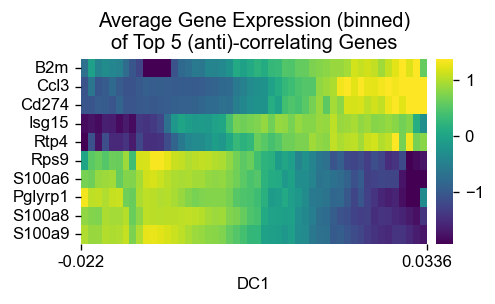

In [68]:
N = 5  # number of top and bottom correlating genes to plot
top = list(df_corr.index[:N])
bot = list(df_corr.index[-N:])
genes = top + bot
binned_mean_exp = pd.DataFrame(index=genes, columns=np.arange(n_bins))
for i in range(n_bins):
    Y = mdata[(X>bins[i]) & (X<bins[i+1]), genes].X.A
    binned_mean_exp[i] = np.mean(Y, axis=0)

from scipy.stats import zscore
T_raw = binned_mean_exp.T.sort_index(ascending=True).T
T = zscore(T_raw, axis=1)
fig, axs = pl.subplots(1, 2, figsize=[4,2], dpi=120, gridspec_kw={'width_ratios': [10, .5], 'wspace': 0.05})
sns.heatmap(T, cmap='viridis', robust=True, ax=axs[0], cbar_ax=axs[1], cbar_kws={'orientation': "vertical"})
axs[0].set_xticks([0, n_bins])
axs[0].set_xticklabels(np.round([xmin, xmax],4))
axs[0].set_xlabel('DC1')
axs[0].set_title(f'Average Gene Expression (binned)\nof Top {N} (anti)-correlating Genes')
pl.savefig(figure_path / f'Fig4D_Neutro_DC1_corr_genes_binned.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [69]:
infl_genes=['CXCL10', 'CCL2', 'CCL5', 'FPR1', 'CCL20', 'IL1A', 'IL8', 'CCL7', 'CCL22', 'CXCL11', 'CCR7', 'EDN1', 'CD40', 'CXCL9', 'IL6', 'IL1B', 'TLR2', 'IL1R1', 'CD69', 'ICAM1', 'CCRL2', 'AQP9', 'EREG', 'C3AR1', 'GNA15', 'CMKLR1', 'PTGER4', 'LIF', 'IL15', 'NAMPT', 'OPRK1', 'ITGB8', 'PTAFR', 'ADM', 'PLAUR', 'NFKB1', 'INHBA', 'OSM', 'TNFSF10', 'TNFSF15', 'IFNGR2', 'EMR1', 'IL12B', 'CSF1', 'CXCL6', 'TNFRSF9', 'LYN', 'ACVR2A', 'LDLR', 'BDKRB1', 'HRH1', 'F3', 'BST2', 'PTGIR', 'CD55', 'CALCRL', 'CSF3', 'GPR132', 'IL4R', 'NLRP3', 'IL15RA', 'ADORA2B', 'GCH1', 'OLR1', 'PTGER2', 'CSF3R', 'MYC', 'RELA', 'TNFAIP6', 'IL7R', 'IL18', 'GABBR1', 'CD82', 'TNFSF9', 'NMUR1', 'IL2RB', 'TLR1', 'LPAR1', 'IRAK2', 'RIPK2', 'MMP14', 'P2RX7', 'SLC11A2', 'SELL', 'P2RY2', 'ABCA1', 'FFAR2', 'PROK2', 'GNAI3', 'TACR1', 'SLC7A1', 'CDKN1A', 'CYBB', 'TIMP1', 'HBEGF', 'SCARF1', 'EBI3', 'NFKBIA', 'SRI', 'SLC7A2', 'CCL17', 'TLR3', 'APLNR', 'OSMR', 'IL10RA', 'PSEN1', 'GPR183', 'ATP2B1', 'TNFRSF1B', 'BEST1', 'GPC3', 'SCN1B', 'ACVR1B', 'HPN', 'SEMA4D', 'KLF6', 'CD48', 'CXCR6', 'SLC1A2', 'GP1BA', 'TAPBP', 'RGS16', 'SLAMF1', 'LCK', 'HIF1A', 'AHR', 'NMI', 'RHOG', 'TPBG', 'NPFFR2', 'IFNAR1', 'ICOSLG', 'RASGRP1', 'IFITM1', 'KCNJ2', 'LY6E', 'IL18R1', 'IL10', 'KCNA3', 'HAS2', 'DCBLD2', 'LAMP3', 'VIP', 'CD70', 'RGS1', 'SLC31A1', 'ADRM1', 'KCNMB2', 'SERPINE1', 'MXD1', 'AXL', 'MEFV', 'PVR', 'CCL24', 'PDE4B', 'LCP2', 'PDPN', 'IRF7', 'MET', 'ATP2A2', 'SLC31A2', 'FZD5', 'ITGA5', 'SGMS2', 'MARCO', 'CD14', 'EIF2AK2', 'ROS1', 'ATP2C1', 'NDP', 'BTG2', 'MSR1', 'PTPRE', 'RNF144B', 'PCDH7', 'SPHK1', 'IL18RAP', 'RTP4', 'RAF1', 'CHST2', 'ITGB3', 'KIF1B', 'SELE', 'NOD2', 'C5AR1', 'EMP3', 'CLEC5A', 'TACR3', 'SLC4A4', 'MEP1A', 'SELS', 'LTA', 'PIK3R5', 'STAB1', 'IRF1', 'ICAM4', 'P2RX4', 'ABI1', 'CX3CL1', 'SLC28A2']
infl_genes = specify_genes(infl_genes, 'human', 'mouse')

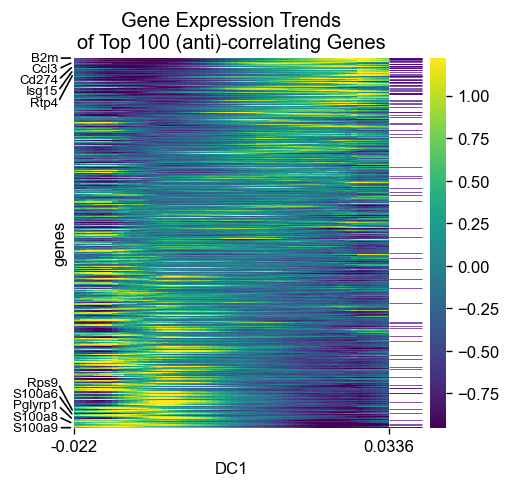

In [71]:
M = 100  # number of genes to use for background
K = 10  # kernel size
x_offset = 0.05  # offset for x-axis labels in fraction
y_spacing = 3  # spacing between y-axis labels in multiples of height increments

background = df_corr.index#list(df_4.index[:M]) + list(df_4.index[-M:])
binned_mean_exp = pd.DataFrame(index=background, columns=np.arange(n_bins))
for i in range(n_bins):
    Y = mdata[(X>bins[i]) & (X<bins[i+1]), background].X.A
    binned_mean_exp[i] = np.mean(Y, axis=0)

from scipy.stats import zscore
T_raw = binned_mean_exp.T.sort_index(ascending=True).T
T = zscore(T_raw, axis=1)
for gene in T.index:
    T.loc[gene] = np.convolve(T.loc[gene], np.ones(K)/K, 'same')

fig, axs = pl.subplots(1, 2, figsize=[4,4], dpi=120, gridspec_kw={'width_ratios': [10, .5], 'wspace': 0.25})
ax = axs[0]
sns.heatmap(T, cmap='viridis', robust=True, ax=ax, cbar_ax=axs[1], cbar_kws={'orientation': "vertical"})
axs[0].set_xticks([0, n_bins])
axs[0].set_xticklabels(np.round([xmin, xmax],4))
ax.set_xlabel('DC1')
ax.set_yticks([ik for ik, k in enumerate(T.index) if k in infl_genes])
ax.yaxis.tick_right()
ax.tick_params('y', length=20, width=.4, which='major', color='indigo')
for i in range(N):
    ax.annotate(bot[N-1-i], xy=(0, i/M), xytext=(-x_offset,y_spacing*i/M), xycoords='axes fraction', ha='right', 
            va='center', fontsize=8)
    ax.annotate('', xy=(0, i/M), xytext=(-x_offset,y_spacing*i/M), xycoords='axes fraction', ha='right', 
            va='center', fontsize=8, arrowprops=dict(arrowstyle="-"))
    ax.annotate(top[i], xy=(0, 1-i/M), xytext=(-x_offset,1-y_spacing*i/M), xycoords='axes fraction', ha='right', 
            va='center', fontsize=8)
    ax.annotate('', xy=(0, 1-i/M), xytext=(-x_offset,1-y_spacing*i/M), xycoords='axes fraction', ha='right', 
            va='center', fontsize=8, arrowprops=dict(arrowstyle="-"))
ax.set_title(f'Gene Expression Trends\nof Top {M} (anti)-correlating Genes')
pl.savefig(figure_path / f'FigS4C_Neutro_DC1_corr_all_genes_binned.png', bbox_inches='tight', dpi=300)
pl.show()

In [72]:
# Export unnormalized data for supplementary table
T_raw.columns.name = 'DC1_bin'
T_raw.to_csv(table_path / f'Fig4D_and_S4C_source.csv')

## Virus

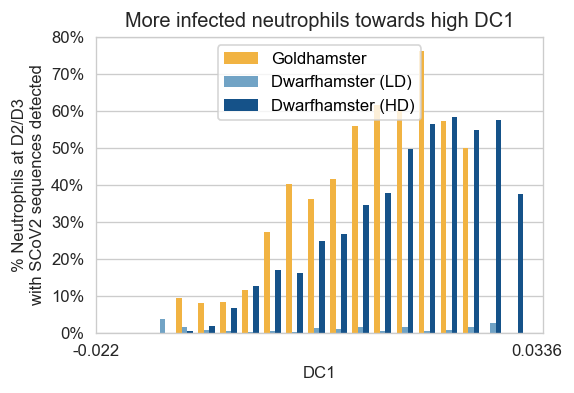

In [78]:
i=1
scale = 0.8
n_bins = 20
dmin = np.min(mdata.obsm['X_diffmap'][:, i])
dmax = np.max(mdata.obsm['X_diffmap'][:, i])

h_virus = np.histogram(mdata.obsm['X_diffmap'][(mdata.obs.SCoV2_detected==True) & (mdata.obs.organism_dosage=='Dwarfhamster_low dose') & (mdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)
h = np.histogram(mdata.obsm['X_diffmap'][(mdata.obs.dosage!='no dose') & (mdata.obs.organism=='Dwarfhamster') & (mdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)
perc_infected_dwarf_ld = h_virus[0] / h[0] * 100

h_virus = np.histogram(mdata.obsm['X_diffmap'][(mdata.obs.SCoV2_detected==True) & (mdata.obs.organism_dosage=='Dwarfhamster_high dose') & (mdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)
h = np.histogram(mdata.obsm['X_diffmap'][(mdata.obs.dosage!='no dose') & (mdata.obs.organism=='Dwarfhamster') & (mdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)
perc_infected_dwarf_hd = h_virus[0] / h[0] * 100

h_virus = np.histogram(mdata.obsm['X_diffmap'][(mdata.obs.SCoV2_detected==True) & (mdata.obs.organism!='Dwarfhamster') & (mdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)
h = np.histogram(mdata.obsm['X_diffmap'][(mdata.obs.dosage!='no dose') & (mdata.obs.organism!='Dwarfhamster') & (mdata.obs.time.isin(['D2', 'D3'])), i], range=[dmin, dmax], bins=n_bins)
perc_infected_gold = h_virus[0] / h[0] * 100

from matplotlib.ticker import PercentFormatter
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, figsize=[6*scale,4*scale], dpi=120)
width = 0.25
ax.bar(np.arange(n_bins)-width, perc_infected_gold, color=organism_dosage_colors['Goldhamster_high dose'], width=width, label='Goldhamster')
ax.bar(np.arange(n_bins), perc_infected_dwarf_ld, color=organism_dosage_colors['Dwarfhamster_low dose'], width=width, label='Dwarfhamster (LD)')
ax.bar(np.arange(n_bins)+width, perc_infected_dwarf_hd, color=organism_dosage_colors['Dwarfhamster_high dose'], width=width, label='Dwarfhamster (HD)')
ax.set_xticks([0, n_bins])
ax.set_xticklabels(np.round([dmin, dmax],4))
ax.yaxis.set_major_formatter(PercentFormatter(100))
ax.set_ylabel('% Neutrophils at D2/D3\nwith SCoV2 sequences detected')
ax.legend()
ax.grid(axis='x')
ax.set_xlabel('DC1')
ax.set_title('More infected neutrophils towards high DC1')
pl.savefig(figure_path / f'FigS4X_Neutro_DC1_perc_infected.pdf', bbox_inches='tight', dpi=300)
pl.show()

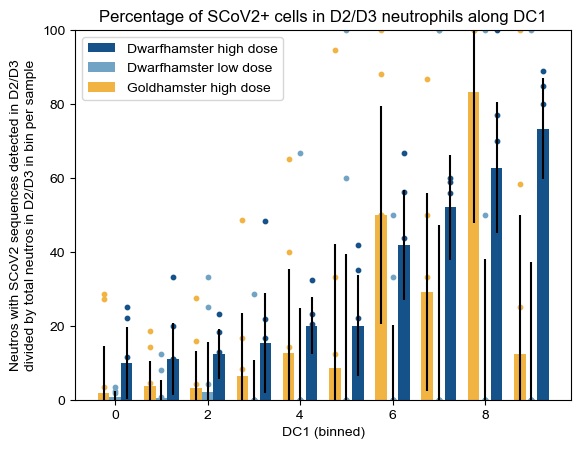

In [35]:
i=1
scale = 0.8
n_bins = 10
dmin = np.percentile(mdata.obsm['X_diffmap'][:, i], 3)
dmax = np.percentile(mdata.obsm['X_diffmap'][:, i],97)

datas = []
for organism, dosage in zip(['Dwarfhamster', 'Dwarfhamster', 'Goldhamster'], ['high dose', 'low dose', 'high dose']):
    base_mask = (mdata.obs.dosage==dosage) & (mdata.obs.organism==organism) & (mdata.obs.time.isin(['D2', 'D3']))
    samples = list(mdata.obs[base_mask]['orig.ident'].unique())
    percs = {}
    for sample in samples:
        sample_mask = base_mask & (mdata.obs['orig.ident']==sample)
        h_virus = np.histogram(mdata.obsm['X_diffmap'][sample_mask & (mdata.obs.SCoV2_detected==True), i], range=[dmin, dmax], bins=n_bins)
        h = np.histogram(mdata.obsm['X_diffmap'][sample_mask, i], range=[dmin, dmax], bins=n_bins)
        perc_infected_dwarf = h_virus[0] / h[0] * 100
        percs[sample] = perc_infected_dwarf
    data = pd.DataFrame(percs).fillna(0)
    datas.append(data)

for i, data in enumerate(datas):
    organism = ['Dwarfhamster', 'Dwarfhamster', 'Goldhamster'][i]
    dosage = ['high dose', 'low dose', 'high dose'][i]
    std = np.std(data, axis=1)
    m = np.median(data, axis=1)
    pl.bar(np.arange(n_bins)-0.25*(i-1), m, 
           yerr=std, width=0.25, 
           label=f'{organism} {dosage}', 
           color=organism_dosage_colors[f'{organism}_{dosage}'])
    for index, row in data.T.iterrows():
        pl.scatter(np.arange(10)-0.25*(i-1), row, s=10, 
                   color=organism_dosage_colors[f'{organism}_{dosage}'])
pl.legend()
pl.ylim(0, 100)
pl.ylabel('Neutros with SCoV2 sequences detected in D2/D3\ndivided by total neutros in D2/D3 in bin per sample')
pl.xlabel('DC1 (binned)')
pl.title('Percentage of SCoV2+ cells in D2/D3 neutrophils along DC1')
pl.show()

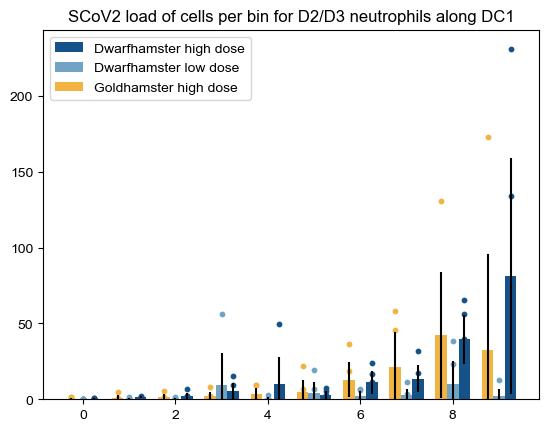

In [36]:
i=1
scale = 0.8
n_bins = 10
dmin = np.percentile(mdata.obsm['X_diffmap'][:, i], 3)
dmax = np.percentile(mdata.obsm['X_diffmap'][:, i],97)

datas = []
for organism, dosage in zip(['Dwarfhamster', 'Dwarfhamster', 'Goldhamster'], ['high dose', 'low dose', 'high dose']):
    base_mask = (mdata.obs.dosage==dosage) & (mdata.obs.organism==organism) & (mdata.obs.time.isin(['D2', 'D3']))
    samples = list(mdata.obs[base_mask]['orig.ident'].unique())
    percs = {}
    for sample in samples:
        sample_mask = base_mask & (mdata.obs['orig.ident']==sample)
        h_virus = np.histogram(mdata.obsm['X_diffmap'][sample_mask & (mdata.obs.SCoV2_detected==True), i],
                               weights=mdata.obs[sample_mask & (mdata.obs.SCoV2_detected==True)]['SCoV2_load'],
                               range=[dmin, dmax], bins=n_bins)
        h = np.histogram(mdata.obsm['X_diffmap'][sample_mask, i], range=[dmin, dmax], bins=n_bins)
        perc_infected_dwarf = h_virus[0] / h[0] * 100
        percs[sample] = perc_infected_dwarf
    data = pd.DataFrame(percs).fillna(0)
    datas.append(data)

for i, data in enumerate(datas):
    organism = ['Dwarfhamster', 'Dwarfhamster', 'Goldhamster'][i]
    dosage = ['high dose', 'low dose', 'high dose'][i]
    mean = np.mean(data, axis=1)
    std = np.std(data, axis=1)
    pl.bar(np.arange(n_bins)-0.25*(i-1), mean, yerr=std, width=0.25, 
           label=f'{organism} {dosage}', color=organism_dosage_colors[f'{organism}_{dosage}'])
    for index, row in data.T.iterrows():
        pl.scatter(np.arange(10)-0.25*(i-1), row, s=10, 
                   color=organism_dosage_colors[f'{organism}_{dosage}'])
pl.legend()
pl.ylim(0, None)
pl.title('SCoV2 load of cells per bin for D2/D3 neutrophils along DC1')
pl.show()

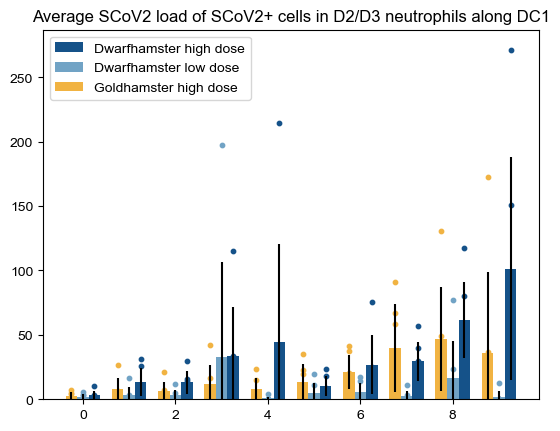

In [37]:
 i=1
scale = 0.8
n_bins = 10
dmin = np.percentile(mdata.obsm['X_diffmap'][:, i], 3)
dmax = np.percentile(mdata.obsm['X_diffmap'][:, i],97)

datas = []
for organism, dosage in zip(['Dwarfhamster', 'Dwarfhamster', 'Goldhamster'], ['high dose', 'low dose', 'high dose']):
    base_mask = (mdata.obs.dosage==dosage) & (mdata.obs.organism==organism) & (mdata.obs.time.isin(['D2', 'D3']))
    samples = list(mdata.obs[base_mask]['orig.ident'].unique())
    percs = {}
    for sample in samples:
        sample_mask = base_mask & (mdata.obs['orig.ident']==sample)
        h_virus = np.histogram(mdata.obsm['X_diffmap'][sample_mask & (mdata.obs.SCoV2_detected==True), i],
                               weights=mdata.obs[sample_mask & (mdata.obs.SCoV2_detected==True)]['SCoV2_load'],
                               range=[dmin, dmax], bins=n_bins)
        h = np.histogram(mdata.obsm['X_diffmap'][sample_mask & (mdata.obs.SCoV2_detected==True), i],
                               range=[dmin, dmax], bins=n_bins)
        perc_infected_dwarf = h_virus[0] / h[0] * 100
        percs[sample] = perc_infected_dwarf
    data = pd.DataFrame(percs).fillna(0)
    datas.append(data)

for i, data in enumerate(datas):
    organism = ['Dwarfhamster', 'Dwarfhamster', 'Goldhamster'][i]
    dosage = ['high dose', 'low dose', 'high dose'][i]
    mean = np.mean(data, axis=1)
    std = np.std(data, axis=1)
    pl.bar(np.arange(n_bins)-0.25*(i-1), mean, yerr=std, width=0.25, 
           label=f'{organism} {dosage}', color=organism_dosage_colors[f'{organism}_{dosage}'])
    for index, row in data.T.iterrows():
        pl.scatter(np.arange(10)-0.25*(i-1), row, s=10, 
                   color=organism_dosage_colors[f'{organism}_{dosage}'])
pl.legend()
pl.title('Average SCoV2 load of SCoV2+ cells in D2/D3 neutrophils along DC1')
pl.ylim(0, None)
pl.show()

## GSEA

In [47]:
# GSEA pre-processing
df = df_corr.copy()
df = df[mdata.var.loc[df.index, 'means'] > np.median(mdata.var.loc[df.index, 'means'])]
df = df[~df.spearman_r.isna()].sort_values('spearman_r', ascending=False)
df.index = specify_genes(df.index, 'mouse', 'human')  # use human gene sets
ranked_genes= df[['spearman_r']]

# run GSEA
pre_res = gp.prerank(rnk=ranked_genes,
                        gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020'],
                        threads=8,
                        min_size=15,  # gene sets with less than that many genes in data are ignored
                        max_size=1000,  # gene sets with more than that many genes in data are ignored
                        permutation_num=1000,
                        outdir=None, # don't write to disk
                        seed=42,
                        verbose=False
                    )
res = extract_gsea_results(pre_res, ["KEGG_2021_Human", 'MSigDB_Hallmark_2020'])
sig_res = res[res['FWER p-val']<0.05]

2023-06-03 15:02:29,598 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


In [48]:
# Export GSEA results
res.to_csv(table_path / 'Fig4E_and_S4A_source.csv')

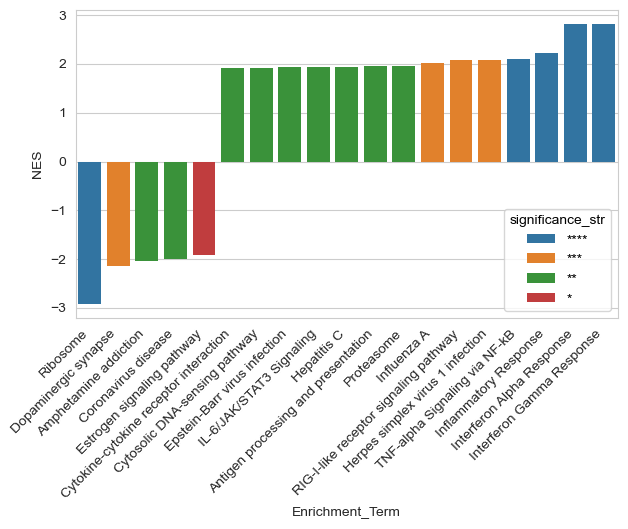

In [49]:
with sns.axes_style("whitegrid"):
    fig, ax = pl.subplots(1, 1, figsize=[7, 4], dpi=100)
sns.barplot(data=sig_res, 
            x='Enrichment_Term', y='NES', 
            hue='significance_str', dodge=False)
pl.xticks(rotation=45, ha='right')
pl.savefig(figure_path / 'FigS4X_Neutro_DC1_dynamics_GSEA.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [50]:
# overlap of lead genes across gene sets
# might use this to cluster gene sets
from sklearn.metrics import jaccard_score
res_ = res[res['FWER p-val']<0.05].copy()
J = pd.DataFrame(index=res_.Enrichment_Term, columns=res_.Enrichment_Term, dtype=float)
for index1 in res_.index:
    genes1 = set(res_.loc[index1, 'Lead_genes'].split(';'))
    for index2 in res_.index:
        genes2 = set(res_.loc[index2, 'Lead_genes'].split(';'))
        jac = len(genes1.intersection(genes2)) / len(genes1.union(genes2))
        J.loc[res_.loc[index1, 'Enrichment_Term'], res_.loc[index2, 'Enrichment_Term']] = jac
J = cluster_matrix(J, how='both')

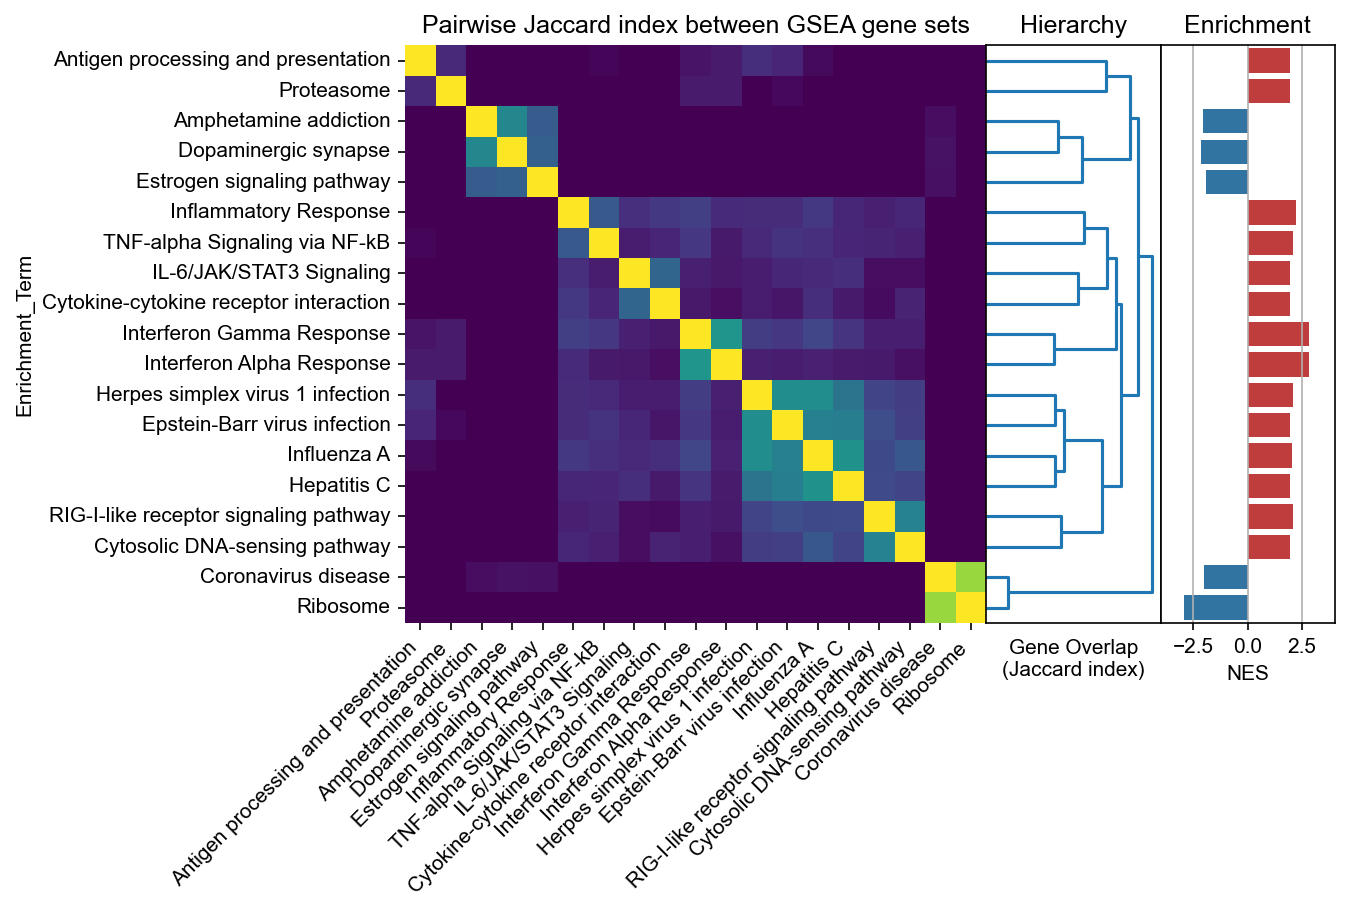

In [51]:
from scipy.cluster import hierarchy
fig, axs = pl.subplots(1, 3, figsize=(5+3, 5), gridspec_kw={'width_ratios': [5, 1.5, 1.5], 'wspace': 0}, dpi=150)

ax = axs[1]
Z = hierarchy.linkage(J, method='average')
dn = hierarchy.dendrogram(Z, orientation='right', labels=J.index, leaf_font_size=8, color_threshold=0, ax=ax)
ax.set_xticks([])
ax.set_xlabel('Gene Overlap\n(Jaccard index)')
order=[x.get_text() for x in ax.get_yticklabels()[::-1]]  # use order from dendrogram
ax.set_yticks([])
ax.set_title('Hierarchy')

ax = axs[0]
sns.heatmap(J.loc[order, order], cmap='viridis', vmin=0, vmax=1, ax=ax, cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('')
ax.set_title('Pairwise Jaccard index between GSEA gene sets')

ax = axs[2]
sig_res['sign'] = sig_res['NES'].apply(lambda x: '+' if x>0 else '-')
sns.barplot(data=sig_res, ax=ax, order=order,
            y='Enrichment_Term', x='NES',
            hue='sign', dodge=False, palette=['tab:blue', 'tab:red'])
ax.legend([],[], frameon=False)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(True, axis='x')
ax.set_title('Enrichment')
ax.set_xlim(-4,4)
pl.savefig(figure_path / 'FigS4A_Neutro_DC1_dynamics_GSEA_grouped_Supplement.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [52]:
# Group gene sets by hierarchical clustering
manual_annotation = {
    'Antigen processing and presentation': 'Antigen processing and presentation',
    'Proteasome': 'Proteasome',
    'Amphetamine addiction': 'Dopamin signaling',
    'Dopaminergic synapse': 'Dopamin signaling',
    'Estrogen signaling pathway': 'Estrogen signaling pathway',
    'Inflammatory Response': 'TNF inflammatory response',
    'TNF-alpha Signaling via NF-kB': 'TNF inflammatory response',
    'IL-6/JAK/STAT3 Signaling': 'IL-6 and cytokine signaling',
    'Cytokine-cytokine receptor interaction': 'IL-6 and cytokine signaling',
    'Interferon Gamma Response': 'Interferon response',
    'Interferon Alpha Response': 'Interferon response',
    'Herpes simplex virus 1 infection': 'Virus infection',
    'Epstein-Barr virus infection': 'Virus infection',
    'Influenza A': 'Virus infection',
    'Hepatitis C': 'Virus infection',
    'RIG-I-like receptor signaling pathway': 'Virus sensing pathways',
    'Cytosolic DNA-sensing pathway': 'Virus sensing pathways',
    'Coronavirus disease': 'Ribosome',
    'Ribosome' : 'Ribosome'
}

# set colors
groups = pd.unique(list(manual_annotation.values()))
color_groups = {g: f'C{i}' for i, g in enumerate(groups)}
color = [color_groups[manual_annotation[g]] for g in manual_annotation.keys()]
sig_res['cluster'] = [manual_annotation[g] for g in sig_res.Enrichment_Term]

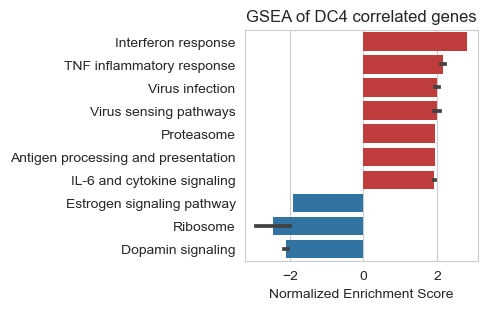

In [53]:
sig_res.sort_values('NES', ascending=False, inplace=True)
with sns.axes_style("whitegrid"):
    fig, ax = pl.subplots(1, 1, figsize=[3, 3], dpi=100)
sns.barplot(data=sig_res, y='cluster', x='NES', ax=ax, hue='sign', dodge=False, 
            palette={'-': 'tab:blue', '+': 'tab:red'})
ax.legend_.remove()
ax.set_xlabel('Normalized Enrichment Score')
ax.set_ylabel('')
ax.set_title('GSEA of DC4 correlated genes')
pl.savefig(figure_path / 'Fig4E_Neutro_DC1_dynamics_GSEA_grouped.pdf', bbox_inches='tight', dpi=300)
pl.show()

## Scores along DC

In [9]:
i=1
mdata.obs[f'DC{i}'] = mdata.obsm['X_diffmap'][:,i]
# get hallmark score columns
c = mdata.obs.columns
keys = list(c[c.str.startswith('HALLMARK_')])

# rank by correlation with DC
LCA = lin_corr_adata(mdata, mdata.obsm['X_diffmap'][:,i], keys, method='spearman')
LCA = LCA[(LCA.spearman_r.abs() > 0.45) & (LCA.spearman_p < 0.05)]
top_keys = list(LCA.index)

100%|██████████| 50/50 [00:00<00:00, 587.44it/s]


In [12]:
# strict sort order for plotting
mdata.obs.Organism_Dosage_ = mdata.obs.Organism_Dosage.astype(str)
mdata.obs.Organism_Dosage_.replace({
'Roborovski hamster, 0 pfu': 2,
'Roborovski hamster, $1\\times10^4$ pfu': 3,
'Roborovski hamster, $1\\times10^5$ pfu': 4,
'Syrian hamster, 0 pfu': 0,
'Syrian hamster, $1\\times10^5$ pfu': 1
}, inplace=True)
index = mdata.obs.Organism_Dosage_.sort_values().index

In [10]:
# smooth lines
dmin = np.min(mdata.obsm['X_diffmap'][:, i])
dmax = np.max(mdata.obsm['X_diffmap'][:, i])
eval_x = np.linspace(dmin, dmax, 30)
results = []
for key in tqdm(top_keys):
    for organism, dosage in zip(['Goldhamster', 'Dwarfhamster', 'Dwarfhamster'], ['high dose', 'low dose', 'high dose']):
        # select organism and dosage, always include no dose of corresponding organism
        mask = (mdata.obs.organism == organism) & ((mdata.obs.dosage == dosage) | (mdata.obs.dosage == 'no dose'))
        smoothed, bottom, top = lowess_with_confidence_bounds(
            mdata.obs[f'DC{i}'][mask], 
            mdata.obs[key][mask], 
            eval_x, N=1, lowess_kw={"frac": 2/3}, conf_interval=0.99)
        sdf = pd.DataFrame([smoothed, bottom, top], index=['smoothed', 'bottom', 'top']).T
        sdf['organism'] = f'{organism}_{dosage}'
        sdf['key'] = key
        sdf['x'] = eval_x
        sdf['Nx'] = np.arange(len(eval_x))
        # count number of cells in each bin for later filtering
        bin_counts, bins_ = np.histogram(mdata.obs[f'DC{i}'][mask], bins=30, range=(dmin, dmax))
        sdf['bin_counts'] = bin_counts
        results.append(sdf)
res = pd.concat(results).reset_index()     

100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


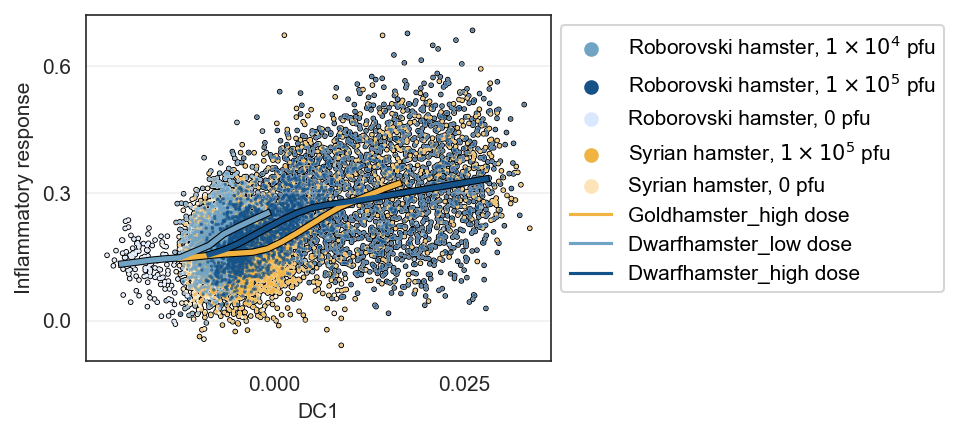

In [15]:
with sns.axes_style("white"):
    fig, ax = pl.subplots(1, 1, figsize=[4, 3], dpi=150, sharex=True, sharey=False, gridspec_kw={'hspace': 0})

key = 'HALLMARK_INFLAMMATORY_RESPONSE'
key_name = key.replace('HALLMARK_', '').capitalize().replace('_', ' ')

ax = scv.pl.scatter(mdata[index], x='DC1', y=key, color='Organism_Dosage', 
                    legend_loc=False, show=False, 
                    title='', ax=ax, alpha=0.7, add_outline=True,
                    palette=Organism_Dosage_colors, s=10,
                    )

# generate low cell count mask, remove points will less than X cells in bin
sres = res[res.key==key]
data = mdata.obs.copy().sample(frac=1)  # shuffle
threshold = sres.groupby('organism').sum()['bin_counts'] * 0.01
cellmask = [(sres.organism==organism) & (sres.bin_counts > threshold[organism]) for organism in sres.organism.unique()]
cellmask = np.any(cellmask, axis=0)
# add outline
sns.lineplot(data=sres[cellmask], x='x', y='smoothed', hue='organism', ax=ax, legend=False,
                palette={k: 'black' for k in organism_dosage_colors.keys()}, linewidth=2.5 + 1)
# add line
sns.lineplot(data=sres[cellmask], x='x', y='smoothed', hue='organism', ax=ax, 
                palette=organism_dosage_colors, linewidth=2.5)

ax.set_ylabel(key_name)#.replace(' ', '\n', 1))
#ax.set_xticklabels([])
ax.set_xlabel(f'DC{i}')
ax.grid(True, axis='y', alpha=0.3)
# for text in ax.legend_.get_texts(): text.set_text(sanitize_name(text.get_text()))  # not working and I do not know why
pl.legend(bbox_to_anchor=(1,1))
pl.savefig(figure_path / f'Fig4X_Neutro_DC{i}_dynamics_{key_name}_grouped.pdf', bbox_inches='tight', dpi=300)
pl.savefig(figure_path / f'Fig4X_Neutro_DC{i}_dynamics_{key_name}_grouped.png', bbox_inches='tight', dpi=300)
pl.show()



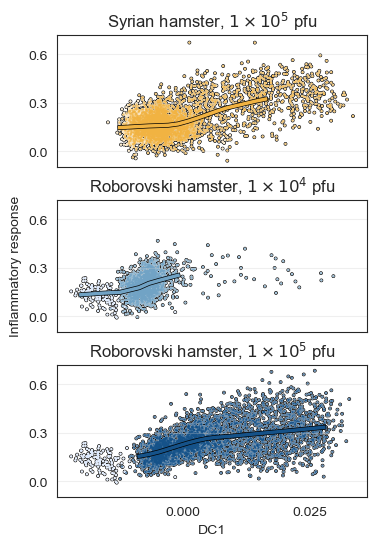

In [18]:
# Plot: split by "line", color by time, Inf Resp only
with sns.axes_style("white"):
    fig, axs = pl.subplots(3, 1, figsize=[4, 6], dpi=100, sharex=True, sharey=True, gridspec_kw={'hspace': 0.25})

organism_dosage_time_colors = config['organism_dosage_time_colors']
for ax, organism in zip(axs, ['Goldhamster_high dose', 'Dwarfhamster_low dose', 'Dwarfhamster_high dose']):
    o, d = organism.split('_')
    key = 'HALLMARK_INFLAMMATORY_RESPONSE'
    sres = res[(res.organism==organism) & (res.key==key)]
    # generate low cell count mask, remove points will less than X cells in bin
    threshold = sres.sum()['bin_counts'] * 0.01
    cellmask = (sres.bin_counts > threshold)
    key_name = key.replace('HALLMARK_', '').capitalize().replace('_', ' ')
    
    not_dosage = 'low dose' if d=='high dose' else 'high dose'
    palette={k.split('_')[-1]: c for k, c in organism_dosage_time_colors.items() if o in k and not_dosage not in k}
    data = mdata.obs[(mdata.obs.organism==o) & (mdata.obs.dosage.isin([d, 'no dose']))].copy().sample(frac=1)  # shuffle
    data.time.cat.remove_unused_categories(inplace=True)
    scv.pl.scatter(mdata[(mdata.obs_names.isin(index)) & (mdata.obs.organism==o) & (mdata.obs.dosage.isin([d, 'no dose']))], x='DC1', y=key, color='Organism_Dosage', 
                    legend_loc=False, show=False, 
                    title='', ax=ax, alpha=0.7, add_outline=True,
                    palette=Organism_Dosage_colors, s=10,
                    )
    
    # add outline
    sns.lineplot(data=sres[cellmask], x='x', y='smoothed', hue='organism', ax=ax, legend=False,
                 palette={k: 'black' for k in organism_dosage_colors.keys()}, linewidth=2.5 + 1)
    # add line
    sns.lineplot(data=sres[cellmask], x='x', y='smoothed', hue='organism', ax=ax, 
                 palette=organism_dosage_colors, linewidth=2.5, legend=False)
    ax.set_title(sanitize_name(organism))
    # ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel('')
    if ax != axs[-1]: ax.set_xlabel('')
    ax.grid(True, axis='y', alpha=0.3)
axs[1].set_ylabel(key_name)
# axs[0].set_xticklabels([])
axs[-1].set_xlabel(f'DC{i}')
pl.savefig(figure_path / f'FigS4X_Neutro_DC{i}_dynamics_{key_name}_grouped.pdf', bbox_inches='tight', dpi=300)
pl.savefig(figure_path / f'FigS4X_Neutro_DC{i}_dynamics_{key_name}_grouped_raster.png', bbox_inches='tight', dpi=300)
pl.show()


# Deprecated

## (DESeq2)

In [ ]:
deseq_path = Path('../results/DESeq2/infection/')
[x.name for x in deseq_path.glob('Neutro*hamster*.csv')]

['Neutrophils_Dwarfhamster_ld_COVID19_vs_healthy.csv',
 'Neutrophils_Dwarfhamster_hd_COVID19_vs_healthy.csv',
 'Neutrophils_Goldhamster_COVID19_vs_healthy.csv']

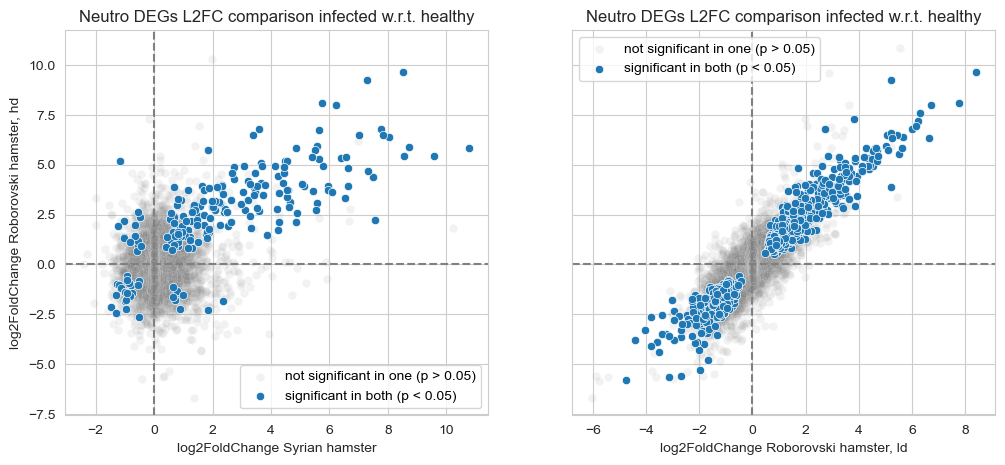

In [ ]:
y = 'Dwarfhamster_hd'
celltype_key = 'Neutrophils'
alpha = 0.05

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, x in zip(axs, ['Goldhamster', 'Dwarfhamster_ld']):
    tab = pd.read_csv(deseq_path / f'{celltype_key}_{x}_COVID19_vs_healthy.csv', index_col=0)
    tab = tab[~tab.index.str.startswith('LOC')]

    tab_ = pd.read_csv(deseq_path / f'{celltype_key}_{y}_COVID19_vs_healthy.csv', index_col=0)
    tab_ = tab_[~tab_.index.str.startswith('LOC')]

    tabo = pd.concat({x: tab, y: tab_}, axis=1)
    tabo = tabo[~(tabo[(x, 'padj')].isna() | tabo[(y, 'padj')].isna())]
    tabo['significant'] = (tabo[(x, 'padj')] < alpha) & (tabo[(y, 'padj')] < alpha)

    scatter_kwargs = dict(x=(x, 'log2FoldChange'), y=(y, 'log2FoldChange'), ax=ax)
    sns.scatterplot(data=tabo[~tabo.significant], 
                    alpha=0.1, color='grey', 
                    label=f'not significant in one (p > {alpha})',
                    **scatter_kwargs)
    sns.scatterplot(data=tabo[tabo.significant], 
                    label=f'significant in both (p < {alpha})',
                    **scatter_kwargs)
    ax.set_xlabel(f'log2FoldChange {sanitize_name(x)}')
    ax.set_ylabel(f'log2FoldChange {sanitize_name(y)}')
    ax.set_title('Neutro DEGs L2FC comparison infected w.r.t. healthy')
    ax.axhline(0, color='grey', linestyle='--')
    ax.axvline(0, color='grey', linestyle='--')
pl.show()

In [ ]:
x = 'Goldhamster'

tab = pd.read_csv(deseq_path / f'{celltype_key}_{x}_COVID19_vs_healthy.csv', index_col=0)
tab = tab[~tab.index.str.startswith('LOC')]

tab_ = pd.read_csv(deseq_path / f'{celltype_key}_{y}_COVID19_vs_healthy.csv', index_col=0)
tab_ = tab_[~tab_.index.str.startswith('LOC')]

tabo = pd.concat({x: tab, y: tab_}, axis=1)
tabo = tabo[~(tabo[(x, 'padj')].isna() | tabo[(y, 'padj')].isna())]
tabo['significant'] = (tabo[(x, 'padj')] < alpha) & (tabo[(y, 'padj')] < alpha)

In [ ]:
# bottom right
genes = list(tabo.index[(tabo[(x, 'log2FoldChange')] > 0) & (tabo[(y, 'log2FoldChange')] < 0)])
res = gp.enrichr(gene_list=genes, gene_sets=['MSigDB_Hallmark_2020'], organism='Mouse').res2d
res = res[res['Adjusted P-value'] < 0.05]
res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Myc Targets V1,72/200,5.157145e-32,2.578572e-30,0,0,7.549299,543.869163,RPL34;HNRNPR;PHB2;RPL6;RRP9;EEF1B2;XPO1;SNRPD3...
1,MSigDB_Hallmark_2020,Oxidative Phosphorylation,56/200,3.308334e-19,8.270835e-18,0,0,5.154668,219.344881,MRPS15;ACADVL;ALAS1;ECI1;MRPL34;PHB2;TOMM22;OP...
2,MSigDB_Hallmark_2020,E2F Targets,39/200,1.051167e-08,1.751945e-07,0,0,3.169054,58.217987,DNMT1;MRE11;SRSF1;SMC6;PDS5B;SMC3;SMC4;GSPT1;P...
3,MSigDB_Hallmark_2020,DNA Repair,29/150,9.449727e-07,1.181216e-05,0,0,3.120103,43.282414,GTF2A2;RALA;RNMT;GMPR2;AK3;GUK1;POLR2H;POLR2J;...
4,MSigDB_Hallmark_2020,Mitotic Spindle,33/199,6.092132e-06,5.665932e-05,0,0,2.588983,31.089839,CEP57;TRIO;EPB41;TUBGCP2;SMC3;ARHGAP5;SMC4;UXT...
5,MSigDB_Hallmark_2020,G2-M Checkpoint,33/200,6.799118e-06,5.665932e-05,0,0,2.573341,30.619453,CUL5;SRSF1;CUL1;PDS5B;SMC4;GSPT1;SMC2;ORC5;XPO...
6,MSigDB_Hallmark_2020,Fatty Acid Metabolism,28/158,8.405851e-06,6.004179e-05,0,0,2.800608,32.729537,ACADVL;ECHS1;RETSAT;ECI1;HSD17B10;BPHL;PTS;LGA...
7,MSigDB_Hallmark_2020,mTORC1 Signaling,32/200,1.775196e-05,1.109497e-04,0,0,2.478617,27.113627,FKBP2;TOMM40;SHMT2;PITPNB;RPN1;SLC1A5;IFI30;RR...
8,MSigDB_Hallmark_2020,Adipogenesis,31/200,4.472038e-05,2.433553e-04,0,0,2.385134,23.887313,SCARB1;SLC27A1;ECHS1;RETSAT;MGST3;MRPL15;SLC1A...
9,MSigDB_Hallmark_2020,Protein Secretion,19/96,4.867105e-05,2.433553e-04,0,0,3.197410,31.751643,COPB2;STX12;DST;CAV2;COPB1;GBF1;SCAMP1;CLCN3;N...


In [ ]:
# top left
genes_ = list(tabo.index[(tabo[(x, 'log2FoldChange')] < 0) & (tabo[(y, 'log2FoldChange')] > 0)])
res_ = gp.enrichr(gene_list=genes_, gene_sets=['MSigDB_Hallmark_2020'], organism='Mouse')
res2d_ = res_.res2d
res2d_ = res2d_[res2d_['Adjusted P-value'] < 0.05]
res2d_

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Apoptosis,31/161,5.396500e-09,1.924298e-07,0,0,3.846891,73.235250,BTG3;BTG2;DIABLO;SATB1;SLC20A1;NEDD9;BCL10;GNA...
1,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,35/200,7.854278e-09,1.924298e-07,0,0,3.427394,63.962729,PPP1R15A;BTG3;BTG2;PTGS2;ETS2;SOCS3;NFIL3;MYC;...
2,MSigDB_Hallmark_2020,Hypoxia,33/200,9.030898e-08,1.475047e-06,0,0,3.186976,51.692835,PPP1R15A;CITED2;HEXA;NEDD4L;CXCR4;ENO1;NR3C1;F...
3,MSigDB_Hallmark_2020,PI3K/AKT/mTOR Signaling,20/105,3.226982e-06,3.953053e-05,0,0,3.769134,47.656791,ATF1;MAP2K3;SMAD2;ACTR3;VAV3;ARF1;RALB;CAB39;U...
4,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,29/199,7.001326e-06,6.314981e-05,0,0,2.741324,32.537896,CD81;PTGER2;FURIN;ENO3;NDRG1;HK2;IGF1R;CCND3;S...
5,MSigDB_Hallmark_2020,p53 Pathway,29/200,7.732629e-06,6.314981e-05,0,0,2.725146,32.075139,RB1;PPP1R15A;BTG2;HDAC3;CD81;ITGB4;FOXO3;RCHY1...
6,MSigDB_Hallmark_2020,TGF-beta Signaling,13/54,1.221697e-05,8.551879e-05,0,0,5.060768,57.250875,PPP1R15A;SLC20A1;IFNGR2;UBE2D3;FURIN;THBS1;RHO...
7,MSigDB_Hallmark_2020,mTORC1 Signaling,28/200,2.138525e-05,1.309846e-04,0,0,2.613485,28.102303,PPP1R15A;BTG2;PSMD12;PSMD13;USO1;UBE2D3;CXCR4;...
8,MSigDB_Hallmark_2020,IL-6/JAK/STAT3 Signaling,16/87,4.765252e-05,2.594415e-04,0,0,3.600255,35.828203,PTPN1;JUN;CSF3R;IFNGR2;STAT3;IL17RA;SOCS3;HAX1...
9,MSigDB_Hallmark_2020,UV Response Up,23/158,6.134166e-05,3.005741e-04,0,0,2.728848,26.467239,KLHDC3;BTG3;BTG2;DGAT1;PRKCD;CEBPG;HNRNPU;FURI...


## (old Scores)

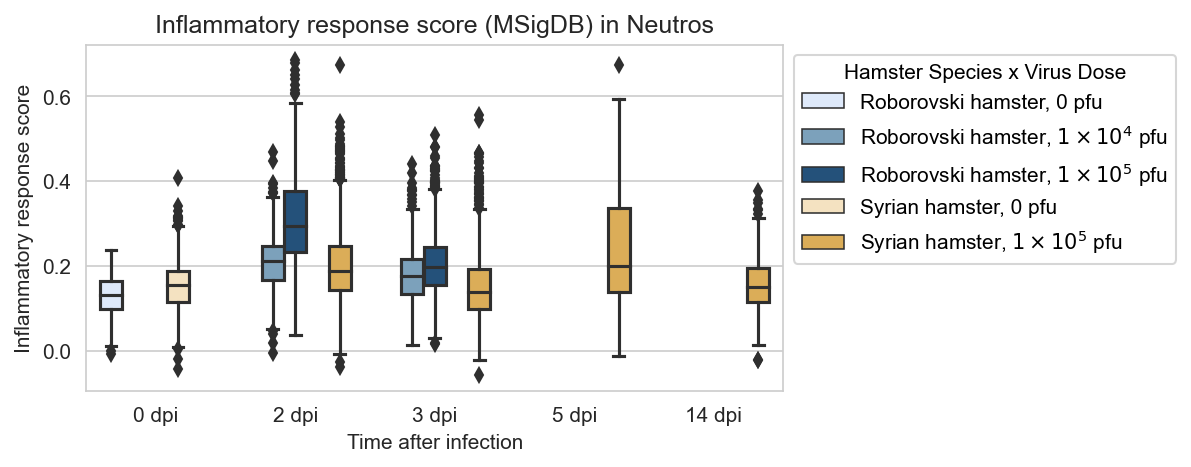

In [ ]:
df = mdata.obs.copy()
key = 'HALLMARK_INFLAMMATORY_RESPONSE'
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(6,3), dpi=150)
sns.boxplot(x='Time', y=key, data=df, palette=Organism_Dosage_colors, hue='Organism_Dosage', ax=ax)
ax.legend_.set_title('Hamster Species x Virus Dose')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
ax.set_title('Inflammatory response score (MSigDB) in Neutros')
ax.set_xlabel('Time after infection')
ax.set_ylabel('Inflammatory response score')
pl.show()